<a href="https://colab.research.google.com/github/Angatang/University-Recommender/blob/main/Tree_Only_Uni_Reco_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install category_encoders xgboost

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from google.colab import drive
from category_encoders import HashingEncoder
from sklearn.impute import SimpleImputer

In [4]:
#Mounting Google Drive
try:
    drive.mount('/content/drive')
    print("Google Drive mounted successfully!")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!


In [5]:
#look for the file in local path
df = pd.read_excel('/content/drive/MyDrive/colab/Data_21-24.xlsx', index_col=0) # index_col=0 might need checking if it was correct
print("Successfully loaded data from Local Drive.")

Successfully loaded data from Local Drive.


In [6]:
UNIVERSITY_RANKING_FILE_PATH = '/content/drive/MyDrive/colab/Other Countries Rankings.xlsx'
# Define the expected column names for university and its rank in your sheets
UNI_NAME_COL_IN_EXCEL = 'Name' # Adjust if the column name is different in your Excel
RANK_COL_IN_EXCEL = 'Rank'             # Adjust if the column name is different in your Excel

print(f"Loading all sheets from Excel file: {UNIVERSITY_RANKING_FILE_PATH}")

try:
    # 1. Load all sheets from the Excel file
    # sheet_name=None loads all sheets into a dictionary of DataFrames
    all_sheets_dict = pd.read_excel(UNIVERSITY_RANKING_FILE_PATH, sheet_name=None)
    print(f"  Successfully loaded {len(all_sheets_dict)} sheets: {list(all_sheets_dict.keys())}")

    # 2. Concatenate all DataFrames from the dictionary
    all_country_rankings_list = []
    for sheet_name, sheet_df in all_sheets_dict.items():
        print(f"    Processing sheet: {sheet_name} with {len(sheet_df)} rows")
        # Ensure the necessary columns exist in the current sheet
        if UNI_NAME_COL_IN_EXCEL not in sheet_df.columns or RANK_COL_IN_EXCEL not in sheet_df.columns:
            print(f"    Warning: Sheet '{sheet_name}' is missing '{UNI_NAME_COL_IN_EXCEL}' or '{RANK_COL_IN_EXCEL}'. Skipping this sheet.")
            continue

        # Select and rename columns to a standard format if needed (already done by UNI_NAME_COL_IN_EXCEL)
        # For this example, we assume the column names are already what we expect.
        # If they were different, you'd rename here:
        # sheet_df = sheet_df.rename(columns={'OldUniName': UNI_NAME_COL_IN_EXCEL, 'OldRank': RANK_COL_IN_EXCEL})

        # Add a column for the source country (sheet name) if useful for context
        sheet_df['SourceCountrySheet'] = sheet_name
        all_country_rankings_list.append(sheet_df[[UNI_NAME_COL_IN_EXCEL, RANK_COL_IN_EXCEL, 'SourceCountrySheet']])

    if not all_country_rankings_list:
        raise ValueError("No valid sheets found or processed. Check column names and Excel file content.")

    combined_rankings_df = pd.concat(all_country_rankings_list, ignore_index=True)
    print(f"\nCombined DataFrame shape before cleaning: {combined_rankings_df.shape}")

    # 3. Clean and Prepare the Combined DataFrame
    # Ensure UniversityName is string and Rank is numeric
    combined_rankings_df[UNI_NAME_COL_IN_EXCEL] = combined_rankings_df[UNI_NAME_COL_IN_EXCEL].astype(str).str.strip()
    combined_rankings_df[RANK_COL_IN_EXCEL] = pd.to_numeric(combined_rankings_df[RANK_COL_IN_EXCEL], errors='coerce')

    # Drop rows where essential information is missing after conversion
    combined_rankings_df.dropna(subset=[UNI_NAME_COL_IN_EXCEL, RANK_COL_IN_EXCEL], inplace=True)
    print(f"Combined DataFrame shape after dropping NaNs in key columns: {combined_rankings_df.shape}")


    # 4. Handle Potential Duplicate University Names
    # If a university appears in multiple sheets (countries), keep its best (lowest) rank.
    # Sort by UniversityName and then by Rank to ensure drop_duplicates keeps the best rank.
    combined_rankings_df.sort_values(by=[UNI_NAME_COL_IN_EXCEL, RANK_COL_IN_EXCEL], ascending=[True, True], inplace=True)
    university_ranking_df = combined_rankings_df.drop_duplicates(subset=[UNI_NAME_COL_IN_EXCEL], keep='first').copy()
    print(f"DataFrame shape after handling duplicates (keeping best rank): {university_ranking_df.shape}")

    # 5. Create a General Worldwide Rank (Optional, if needed as a new sequential rank)
    # Sort by the existing rank (lower is better)
    university_ranking_df.sort_values(by=RANK_COL_IN_EXCEL, ascending=True, inplace=True)
    # Assign a new sequential rank column
    university_ranking_df['WorldwideRank'] = range(1, len(university_ranking_df) + 1)

    # Rename columns to the standard names expected by the imputation function
    # (e.g., 'UniversityName' and 'Rank' if RANK_COL_IN_EXCEL was different)
    # If UNI_NAME_COL_IN_EXCEL was different from 'UniversityName', rename it:
    # university_ranking_df.rename(columns={UNI_NAME_COL_IN_EXCEL: 'UniversityName'}, inplace=True)
    # The imputation function expects a column named 'Rank' for sorting.
    # If your original rank column was different, ensure it's now named 'Rank' or adjust the imputation function.
    # For this example, we'll ensure the main rank column is just 'Rank'.
    if RANK_COL_IN_EXCEL != 'Rank':
         university_ranking_df.rename(columns={RANK_COL_IN_EXCEL: 'Rank'}, inplace=True)


    print("\nFinal Processed University Ranking DataFrame ('university_ranking_df'):")
    print(university_ranking_df.head())
    print(f"Total unique universities in final ranking: {len(university_ranking_df)}")

except FileNotFoundError:
    print(f"Error: The Excel file was not found at '{UNIVERSITY_RANKING_FILE_PATH}'. Please check the path.")
    university_ranking_df = pd.DataFrame(columns=['Name', 'Rank']) # Create empty df
except ValueError as ve:
    print(f"ValueError during processing: {ve}")
    university_ranking_df = pd.DataFrame(columns=['Name', 'Rank'])
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()
    university_ranking_df = pd.DataFrame(columns=['Name', 'Rank'])

# Now, 'university_ranking_df' should contain columns 'UniversityName', 'Rank' (the best original rank),
# 'SourceCountrySheet' (optional context), and 'WorldwideRank' (new sequential rank).
# This 'university_ranking_df' can be used in your custom imputation logic.
# Ensure the column used for ranking in the imputation function is 'Rank'.

Loading all sheets from Excel file: /content/drive/MyDrive/colab/Other Countries Rankings.xlsx
  Successfully loaded 6 sheets: ['Austraila', 'Germany', 'New Zealand', 'UK', 'United States of America', 'Ireland']
    Processing sheet: Austraila with 38 rows
    Processing sheet: Germany with 51 rows
    Processing sheet: New Zealand with 9 rows
    Processing sheet: UK with 161 rows
    Processing sheet: United States of America with 182 rows
    Processing sheet: Ireland with 9 rows

Combined DataFrame shape before cleaning: (441, 3)
Combined DataFrame shape after dropping NaNs in key columns: (111, 3)
DataFrame shape after handling duplicates (keeping best rank): (111, 3)

Final Processed University Ranking DataFrame ('university_ranking_df'):
                                      Name  Rank        SourceCountrySheet  \
89                    University of Oxford   1.0                        UK   
250  Massachusetts Institute of Technology   2.0  United States of America   
251        

In [7]:
df.columns.tolist()

['Email',
 'Gender',
 'Interested Countries',
 'Parent Phone Number',
 'Student Phone Number',
 'Passport Number',
 'Requires Essay',
 'Requires Lor',
 'Requires Sop',
 'Term Name',
 'UserId',
 'Total Fees Charged',
 'Fees Paid',
 'Expected Payment Date',
 'Date Of Birth',
 'Account Created On',
 'Account Created By',
 'Branch',
 'Other Remarks',
 'Language Exam',
 'Is Language Exam Given',
 'Total Score (Language Exam)',
 'Competitive Exam',
 'Is Competitive Exam Given',
 'Total Score (Competitive Exam)',
 'Current Education',
 'Future Desired Degree',
 'Desired Course',
 'Desired Field of Study',
 'Desired Specialization',
 'University Suggestion State',
 'Suggested Universities',
 'Finalized University',
 'CWID Number',
 'Partner Name',
 'Grading Systen',
 'College Details',
 'First Year Score',
 'Second Year Score',
 'Third Year Score',
 'Fourth Year Score',
 'Fifth Year Score',
 'Sixth Year Score',
 'Seventh Year Score',
 'Eighth Year Score',
 'Profile Statuses']

In [8]:
# --- Code to Clean Column Names ---
print("\nCleaning column names (replacing spaces with underscores)...")

# Use df.rename with a lambda function and regex substitution
# x.strip() removes leading/trailing whitespace
# re.sub(r'\s+', '_', ...) replaces one or more whitespace characters (\s+) with a single underscore
df = df.rename(columns=lambda x: re.sub(r'\s+', '_', x.strip()))

# --- Verify the changes ---
print("\nCleaned columns:")
print(df.columns.tolist())



Cleaning column names (replacing spaces with underscores)...

Cleaned columns:
['Email', 'Gender', 'Interested_Countries', 'Parent_Phone_Number', 'Student_Phone_Number', 'Passport_Number', 'Requires_Essay', 'Requires_Lor', 'Requires_Sop', 'Term_Name', 'UserId', 'Total_Fees_Charged', 'Fees_Paid', 'Expected_Payment_Date', 'Date_Of_Birth', 'Account_Created_On', 'Account_Created_By', 'Branch', 'Other_Remarks', 'Language_Exam', 'Is_Language_Exam_Given', 'Total_Score_(Language_Exam)', 'Competitive_Exam', 'Is_Competitive_Exam_Given', 'Total_Score_(Competitive_Exam)', 'Current_Education', 'Future_Desired_Degree', 'Desired_Course', 'Desired_Field_of_Study', 'Desired_Specialization', 'University_Suggestion_State', 'Suggested_Universities', 'Finalized_University', 'CWID_Number', 'Partner_Name', 'Grading_Systen', 'College_Details', 'First_Year_Score', 'Second_Year_Score', 'Third_Year_Score', 'Fourth_Year_Score', 'Fifth_Year_Score', 'Sixth_Year_Score', 'Seventh_Year_Score', 'Eighth_Year_Score', 'P

In [9]:
if 'Is_Competitive_Exam_Given' in df.columns:
    print("Column 'Is_Competitive_Exam_Given' exists in df.")
    print("Value Counts (including NaNs):")
    print(df['Is_Competitive_Exam_Given'].value_counts(dropna=False))
    # Check data type as well
    print(f"Data type: {df['Is_Competitive_Exam_Given'].dtype}")

    # re-check the scores *before* they are potentially overwritten
    # Make sure the column name is correct for raw data before conversion
    print("\nChecking original competitive scores in df (after potential to_numeric):")
    original_scores = pd.to_numeric(df['Total_Score_(Competitive_Exam)'], errors='coerce')
    print(original_scores.value_counts(dropna=False))

else:
    print("ERROR: Column 'Is_Competitive_Exam_Given' DOES NOT EXIST in df!")

Column 'Is_Competitive_Exam_Given' exists in df.
Value Counts (including NaNs):
Is_Competitive_Exam_Given
1.0    2331
0.0    1401
NaN     104
Name: count, dtype: int64
Data type: float64

Checking original competitive scores in df (after potential to_numeric):
Total_Score_(Competitive_Exam)
NaN       1505
305.0       74
304.0       73
312.0       70
314.0       69
          ... 
740.0        1
480.0        1
1290.0       1
1050.0       1
840.0        1
Name: count, Length: 127, dtype: int64


In [10]:
print("\nParsing College Details...")

def parse_college_details(details):
    if pd.isna(details):
        return pd.Series([np.nan] * 4) # Return NaNs if input is NaN

    # Regex to capture: Major, College, University, Year
    # Adjust pattern if format varies significantly
    # Using non-greedy matching (.*?) and being specific about keywords
    pattern = r"^(.*?),\s*College:\s*(.*?),\s*University:\s*(.*?),\s*Year:\s*(\d{4})$"
    match = re.search(pattern, str(details).strip())

    if match:
        ug_major = match.group(1).strip()
        ug_college = match.group(2).strip()
        ug_university = match.group(3).strip()
        ug_year = int(match.group(4)) # Convert year to integer
        return pd.Series([ug_major, ug_college, ug_university, ug_year])
    else:
        year_match = re.search(r"Year:\s*(\d{4})", str(details))
        ug_year = int(year_match.group(1)) if year_match else np.nan
        return pd.Series([np.nan] * 3 + [ug_year]) # Example fallback

# Apply the function to create new columns
parsed_cols = ['UG_Major', 'UG_College_Name', 'UG_University_Name', 'UG_Year_of_Graduation']
df[parsed_cols] = df['College_Details'].apply(parse_college_details)



Parsing College Details...


In [11]:
from datetime import datetime
import numpy as np # Ensure numpy is imported

print("\nCreating 'Years_Since_Grad' feature...")

# Get the current year
current_year = datetime.now().year

# Ensure the UG_Year_of_Graduation column exists and is numeric
if 'UG_Year_of_Graduation' in df.columns:
    # Convert to numeric, coercing errors just in case
    df['UG_Year_of_Graduation'] = pd.to_numeric(df['UG_Year_of_Graduation'], errors='coerce')

    # Calculate years since graduation
    df['Years_Since_Grad'] = current_year - df['UG_Year_of_Graduation']

    # Handle cases where graduation year might be in the future (set to 0)
    df.loc[df['Years_Since_Grad'] < 0, 'Years_Since_Grad'] = 0

    print("Created 'Years_Since_Grad' feature.")
    # print(df[['UG_Year_of_Graduation', 'Years_Since_Grad']].head()) # Optional: Verify
else:
    print("Skipping 'Years_Since_Grad': 'UG_Year_of_Graduation' column not available.")


Creating 'Years_Since_Grad' feature...
Created 'Years_Since_Grad' feature.


In [12]:
print("\nCalculating Overall GPA on 4.0 Scale...")

# Define the list of score columns
score_columns = [
    'First_Year_Score', 'Second_Year_Score', 'Third_Year_Score',
    'Fourth_Year_Score', 'Fifth_Year_Score', 'Sixth_Year_Score',
    'Seventh_Year_Score', 'Eighth_Year_Score'
]

# Convert score columns to numeric, coercing errors to NaN
for col in score_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

def calculate_gpa_4_scale(row):
    system = row['Grading_Systen']
    scores = row[score_columns].tolist()
    valid_scores = []

    if pd.isna(system):
        return np.nan

    # Determine scale and outlier bounds
    max_scale = np.nan
    lower_bound = np.nan
    upper_bound = np.nan

    if system == 'CGPA10':
        max_scale = 10.0
        lower_bound = 1.0 # Adjust if lower scores are valid
        upper_bound = 10.0
    elif system == 'GPA7':
        max_scale = 7.0
        lower_bound = 1.0 # Adjust if lower scores are valid
        upper_bound = 7.0
    elif system == 'Default': # Percentage scale
        max_scale = 100.0
        lower_bound = 35.0 # Assuming scores below 35% are outliers/fails to ignore
        upper_bound = 100.0
    else: # Handle unexpected systems
        return np.nan

    # Filter scores
    for score in scores:
        if pd.notna(score) and lower_bound <= score <= upper_bound:
             valid_scores.append(score)

    # Calculate average and convert
    if not valid_scores: # Check if list is empty
        return np.nan
    else:
        average_score = sum(valid_scores) / len(valid_scores)
        return (average_score / max_scale) * 4.0

# Apply the function row-wise
df['Overall_GPA_4_Scale'] = df.apply(calculate_gpa_4_scale, axis=1)



Calculating Overall GPA on 4.0 Scale...


In [13]:
print("\nHandling Test Scores")

# Define Max Scores
MAX_SCORES = {
    'GRE': 340,
    'GMAT': 800,  # Traditional GMAT Max
    'SAT': 1600,
    'ACT': 36
}

# --- Language Exam ---
lang_score_col = 'Total_Score_(Language_Exam)'
lang_given_col = 'Is_Language_Exam_Given'
df[lang_score_col] = pd.to_numeric(df[lang_score_col], errors='coerce')
df[lang_given_col] = pd.to_numeric(df[lang_given_col], errors='coerce')
df.loc[(df[lang_given_col] == 0.0) | (df[lang_given_col].isna()), lang_score_col] = 0
df.loc[(df[lang_given_col] == 1.0) & (df[lang_score_col].isna()), lang_score_col] = -2

# --- Competitive Exam ---
comp_score_col = 'Total_Score_(Competitive_Exam)'
comp_given_col = 'Is_Competitive_Exam_Given'
comp_exam_type_col = 'Competitive_Exam' # Column specifying GRE/GMAT/SAT/ACT

# Ensure score column is numeric
df[comp_score_col] = pd.to_numeric(df[comp_score_col], errors='coerce')
# Ensure 'Is Given' column is numeric/float
df[comp_given_col] = pd.to_numeric(df[comp_given_col], errors='coerce')

# Apply logic based on the 'Is Given' flag (1.0 = Yes, 0.0 = No, NaN = Treat as No)
df.loc[(df[comp_given_col] == 0.0) | (df[comp_given_col].isna()), comp_score_col] = 0
df.loc[(df[comp_given_col] == 1.0) & (df[comp_score_col].isna()), comp_score_col] = -2

# !!! CAPPING LOGIC !!!
# Ensure the Exam Type column is string and handle potential NaNs
df[comp_exam_type_col] = df[comp_exam_type_col].astype(str).fillna('UNKNOWN')

print("Applying score capping...")
for exam_type, max_score in MAX_SCORES.items():
    # Condition for rows matching the exam type AND score exceeding max
    condition = (
        (df[comp_exam_type_col].str.upper() == exam_type) &
        (df[comp_score_col] > max_score)
    )
    # Apply capping
    count_capped = condition.sum()
    if count_capped > 0:
        print(f"Capping {count_capped} scores for {exam_type} at {max_score}")
        df.loc[condition, comp_score_col] = max_score

# --- Verification ---
print("Sample processed test scores (Corrected + Capped):")
print(df[[lang_given_col, lang_score_col, comp_given_col, comp_score_col, comp_exam_type_col]].head())
print("\nValue counts for Competitive Score after correction + capping:")
# Check if capping worked by looking at max values per exam type if needed
# print(df_us.groupby(comp_exam_type_col)[comp_score_col].max())
print(df[comp_score_col].value_counts(dropna=False))


Handling Test Scores
Applying score capping...
Sample processed test scores (Corrected + Capped):
                       Is_Language_Exam_Given  Total_Score_(Language_Exam)  \
Full Name                                                                    
Aniket Dandawate                          0.0                          0.0   
Abhiroop Ramachandran                     1.0                        107.0   
MANALI BHOSLE                             1.0                          6.0   
Shivani Zemse                             1.0                        107.0   
Gaurav Purohit                            1.0                        107.0   

                       Is_Competitive_Exam_Given  \
Full Name                                          
Aniket Dandawate                             0.0   
Abhiroop Ramachandran                        1.0   
MANALI BHOSLE                                0.0   
Shivani Zemse                                1.0   
Gaurav Purohit                            

In [14]:
# --- Create StudentID and Select Columns for Restructuring ---

print("\nCreating 'StudentID' column from index...")
# Directly create the StudentID column from the DataFrame's current index
# This ensures the column exists for the subsequent check.
try:
    df['StudentID'] = df.index
    print("'StudentID' column created successfully.")


except Exception as e:
    print(f"ERROR during StudentID creation: {e}")
    raise # Re-raise the error to stop execution if StudentID creation fails


# Define the list of student features to carry into the interaction data
# Ensure these use the cleaned (underscore) column names
student_features_to_keep = [
    'Overall_GPA_4_Scale',
    'Total_Score_(Language_Exam)', # Use cleaned/capped scores
    'Total_Score_(Competitive_Exam)', # Use cleaned/capped scores
    'Language_Exam',
    'Competitive_Exam',
    'Future_Desired_Degree',
    'Desired_Field_of_Study',
    'Desired_Specialization',
    'Years_Since_Grad'
    # Add/remove features as decided from your feature engineering
]
# Also list columns needed specifically for restructuring logic
other_required_cols = ['Suggested_Universities', 'StudentID']

# Check if all required columns exist before proceeding
required_cols_check = [col for col in student_features_to_keep if col in df.columns] + \
                      [col for col in other_required_cols if col in df.columns]
# Find any expected columns that are ACTUALLY missing from df at this point
all_expected_cols = student_features_to_keep + other_required_cols
missing_cols_check = [col for col in all_expected_cols if col not in df.columns]

if missing_cols_check:
    # This error should not be raised now if StudentID was created correctly
    raise ValueError(f"Missing required columns before restructuring: {missing_cols_check}")
else:
    print("All required columns for restructuring found.")
    # Select only the necessary columns for the next steps
    df_for_restructure = df[required_cols_check].copy()
    print(f"Created 'df_for_restructure' with shape: {df_for_restructure.shape}")



Creating 'StudentID' column from index...
'StudentID' column created successfully.
All required columns for restructuring found.
Created 'df_for_restructure' with shape: (3836, 11)


In [15]:
# --- Parsing Function ---
def parse_suggestions(text):
    suggestions = []
    if isinstance(text, str):
        lines = text.split('\n')
        for line in lines:
            parts = line.split('|')
            if len(parts) >= 2:
                uni_name = parts[0].strip()
                status = parts[1].strip().upper()
                if uni_name:
                    suggestions.append({'UniversityName': uni_name, 'Status': status})
    return suggestions


In [16]:
# --- Generate Positive and Potential Negative Examples ---
print("Parsing suggestions and generating examples...")
all_examples_rows = []
positive_statuses = ['ADMITRECEIVED', 'FINALIZED', 'ACCEPTED'] # Define positive statuses

for index, student_row in df_for_restructure.iterrows():
    student_id = student_row['StudentID']
    suggestions_text = student_row['Suggested_Universities']
    parsed_list = parse_suggestions(suggestions_text)
    if not parsed_list: continue

    student_features = student_row[student_features_to_keep].to_dict()

    for suggestion in parsed_list:
        example_row = student_features.copy()
        example_row['StudentID'] = student_id
        example_row['UniversityName'] = suggestion['UniversityName']
        status = suggestion['Status']
        example_row['Admitted'] = 1 if status in positive_statuses else 0
        all_examples_rows.append(example_row)

if not all_examples_rows:
     raise ValueError("No examples generated. Check 'Suggested Universities' data/parsing.")

all_examples_df = pd.DataFrame(all_examples_rows)
print(f"Generated {all_examples_df.shape[0]} raw examples.")


Parsing suggestions and generating examples...
Generated 19631 raw examples.


In [17]:
all_examples_df.columns.tolist()

['Overall_GPA_4_Scale',
 'Total_Score_(Language_Exam)',
 'Total_Score_(Competitive_Exam)',
 'Language_Exam',
 'Competitive_Exam',
 'Future_Desired_Degree',
 'Desired_Field_of_Study',
 'Desired_Specialization',
 'Years_Since_Grad',
 'StudentID',
 'UniversityName',
 'Admitted']

In [18]:
TARGET_COLUMN = 'Admitted' # Standardized target column name

# --- Load the two new CSV files (GradCafe data) ---
# Using the paths you provided
try:
    new_data1_raw = pd.read_csv('/content/drive/MyDrive/colab/gradcafe_20-22_results.csv')
    new_data2_raw = pd.read_csv('/content/drive/MyDrive/colab/gradcafe_22-25_results.csv')
    print("New data files (GradCafe) loaded successfully.")

    # --- Data Cleaning & Renaming for New Data ---
    # Pass TARGET_COLUMN as an argument
    def preprocess_new_data(df, df_name, target_col_name):
        """
        Preprocesses the raw GradCafe dataframes:
        - Renames columns to match original data conventions.
        - Derives the binary target column ('Admitted').
        - Extracts numerical GPA from string format.
        - Applies a heuristic conversion to attempt standardizing GPA to 4.0 scale.
        - Converts competitive exam score to numeric.
        """
        print(f"Preprocessing {df_name}...")
        # Create a copy to avoid SettingWithCopyWarning
        df = df.copy()
        # Rename columns to match original_df conventions
        df = df.rename(columns={
            'Institution': 'UniversityName',
            'Program': 'Desired_Field_of_Study', # Requires validation if format differs
            'Degree': 'Future_Desired_Degree',
            'GPA': 'Overall_GPA_4_Scale',       # Will attempt extraction & heuristic conversion below
            'GRE_Score': 'Total_Score_(Competitive_Exam)' # Represents GRE score here
        })

        # --- Create the standardized TARGET_COLUMN ---
        # Use the passed target_col_name
        print(f"  Deriving '{target_col_name}' from 'Decision' column...")
        # Ensure 'Decision' column exists before processing
        if 'Decision' in df.columns:
             df[target_col_name] = np.where(df['Decision'].astype(str).str.contains('Accepted', case=False, na=False), 1, 0)
             print(f"    Value counts for {target_col_name}:\n{df[target_col_name].value_counts(dropna=False)}")
        else:
             print(f"    Warning: 'Decision' column not found in {df_name}. Cannot derive '{target_col_name}'.")
             df[target_col_name] = np.nan # Assign NaN if source column is missing


        # --- Data Cleaning & Heuristic GPA Conversion ---
        gpa_col = 'Overall_GPA_4_Scale'
        print(f"  Attempting extraction and heuristic conversion for '{gpa_col}'...")

        # Check if the renamed GPA column exists
        if gpa_col in df.columns:
            # --- Extract numerical part from GPA string ---
            print(f"    Extracting numerical value from '{gpa_col}' string...")
            # Convert to string first, handle potential NaNs introduced by copy/rename
            df[gpa_col] = df[gpa_col].astype(str).str.extract(r'(\d+\.?\d*)', expand=False)
            print(f"    NaN count in '{gpa_col}' after extraction: {df[gpa_col].isnull().sum()}")

            # Ensure column is numeric after extraction
            df[gpa_col] = pd.to_numeric(df[gpa_col], errors='coerce')
            print(f"    NaN count in '{gpa_col}' after to_numeric: {df[gpa_col].isnull().sum()}")

            # Define conversion function with heuristic rules
            def heuristic_gpa_conversion(gpa):
                if pd.isnull(gpa):
                    return np.nan
                elif gpa < 1.0: # Unlikely to be valid GPA on any common scale
                     return np.nan
                elif gpa <= 4.0: # Assume already 4.0 scale
                    return gpa
                elif gpa <= 7.0: # Assume 7.0 scale
                    return gpa * (4.0 / 7.0)
                elif gpa <= 10.0: # Assume 10.0 scale
                    return gpa * (4.0 / 10.0)
                else: # Likely invalid (e.g., > 10)
                    return np.nan

            # Apply the conversion
            # IMPORTANT: This is a heuristic guess and may be inaccurate for many entries!
            print(f"    Applying heuristic GPA scale conversion...")
            original_gpa_non_null = df[gpa_col].notnull().sum()
            df[gpa_col] = df[gpa_col].apply(heuristic_gpa_conversion)
            converted_gpa_non_null = df[gpa_col].notnull().sum()
            print(f"    Applied heuristic GPA conversion. Non-null count changed from {original_gpa_non_null} to {converted_gpa_non_null}.")
            print(f"    NaN count in '{gpa_col}' after heuristic: {df[gpa_col].isnull().sum()}")
        else:
            print(f"    Warning: Column '{gpa_col}' not found after renaming in {df_name}. Skipping GPA processing.")


        # Convert GRE score to numeric
        gre_col = 'Total_Score_(Competitive_Exam)'
        print(f"  Converting '{gre_col}' to numeric...")
        if gre_col in df.columns:
            # Use .loc to modify the DataFrame slice safely
            df.loc[:, gre_col] = pd.to_numeric(df[gre_col], errors='coerce')
            print(f"    NaN count in '{gre_col}' after to_numeric: {df[gre_col].isnull().sum()}")
        else:
             print(f"    Warning: Column '{gre_col}' not found after renaming in {df_name}. Skipping GRE conversion.")


        return df

    # Call the function passing TARGET_COLUMN
    new_data1 = preprocess_new_data(new_data1_raw, 'new_data1', TARGET_COLUMN)
    new_data2 = preprocess_new_data(new_data2_raw, 'new_data2', TARGET_COLUMN)

except FileNotFoundError as e:
    print(f"Error loading new data files: {e}")
    print("Please ensure the file paths are correct.")
    # Assign empty dataframes if loading fails to prevent later errors
    new_data1, new_data2 = pd.DataFrame(), pd.DataFrame() # Create empty DFs
except Exception as e:
    print(f"Error processing new data files: {e}")
    import traceback
    traceback.print_exc() # Print full traceback for debugging
    # Assign empty dataframes if processing fails
    new_data1, new_data2 = pd.DataFrame(), pd.DataFrame() # Create empty DFs

print("\nData loading and initial preprocessing complete.")
# NOTE: This code assumes 'original_df_loaded' (your 'all_examples_df') is already loaded
# and available in the notebook's memory from a previous cell.
# The dataframes 'new_data1' and 'new_data2' are now preprocessed.

New data files (GradCafe) loaded successfully.
Preprocessing new_data1...
  Deriving 'Admitted' from 'Decision' column...
    Value counts for Admitted:
Admitted
0    64740
1    39780
Name: count, dtype: int64
  Attempting extraction and heuristic conversion for 'Overall_GPA_4_Scale'...
    Extracting numerical value from 'Overall_GPA_4_Scale' string...
    NaN count in 'Overall_GPA_4_Scale' after extraction: 66950
    NaN count in 'Overall_GPA_4_Scale' after to_numeric: 66950
    Applying heuristic GPA scale conversion...
    Applied heuristic GPA conversion. Non-null count changed from 37570 to 37565.
    NaN count in 'Overall_GPA_4_Scale' after heuristic: 66955
  Converting 'Total_Score_(Competitive_Exam)' to numeric...
    NaN count in 'Total_Score_(Competitive_Exam)' after to_numeric: 86292
Preprocessing new_data2...
  Deriving 'Admitted' from 'Decision' column...
    Value counts for Admitted:
Admitted
0    73182
1    41938
Name: count, dtype: int64
  Attempting extraction and he

In [19]:
# --- 2. Define Core Features to Keep (Revising to add back features) ---
# Based on overlap between all_examples_df and new_data sources,
# PLUS columns from original data we want to impute where missing in new data.
core_features = [
    'UniversityName',             # Mapped from Institution
    'Desired_Field_of_Study',     # Mapped from Program
    'Future_Desired_Degree',      # Mapped from Degree
    'Overall_GPA_4_Scale',        # Mapped from GPA (Extracted & Heuristically converted)
    'Total_Score_(Competitive_Exam)', # Mapped from GRE_Score
    'Total_Score_(Language_Exam)',  # Exists only in original data
    'Years_Since_Grad'            # Exists only in original data
]
print(f"\nCore features selected for model training: {core_features}")

# Select only core features and the target column from all dataframes
try:
    # Ensure all_examples_df is defined and has the necessary columns
    if 'all_examples_df' not in locals():
         raise NameError("'all_examples_df' is not defined. Please ensure it was loaded/assigned correctly in a previous cell.")

    print(f"\nFiltering original dataframe (all_examples_df)...")
    # Check if TARGET_COLUMN exists before filtering
    if TARGET_COLUMN not in all_examples_df.columns:
        raise KeyError(f"Target column '{TARGET_COLUMN}' not found in all_examples_df. Please create it if necessary.")
    # Check if all core_features exist in all_examples_df
    missing_cols_original = [col for col in core_features if col not in all_examples_df.columns]
    if missing_cols_original:
        # If columns are missing ONLY from original, it's an issue with original data/generation
        raise KeyError(f"Core features missing from all_examples_df: {missing_cols_original}")

    original_df_filtered = all_examples_df[core_features + [TARGET_COLUMN]].copy()

    # Ensure numerical columns in original data are numeric
    print(f"  Ensuring numerical columns in original data are numeric...")
    num_cols_to_check = ['Overall_GPA_4_Scale', 'Total_Score_(Competitive_Exam)', 'Total_Score_(Language_Exam)', 'Years_Since_Grad']
    for col in num_cols_to_check:
         if col in original_df_filtered.columns:
              original_df_filtered[col] = pd.to_numeric(original_df_filtered[col], errors='coerce')
              print(f"    NaN count in '{col}' in original data: {original_df_filtered[col].isnull().sum()}")
         else:
              # This case was already checked by missing_cols_original, but good for clarity
              print(f"    Warning: Column '{col}' not found in original data.")
    print(f"  Shape after filtering: {original_df_filtered.shape}")


    # --- Prepare New Data (Add missing columns with NaNs) ---
    # The new dataframes only have a subset of core_features after preprocessing.
    # We need to add the columns that are ONLY in the original data, filled with NaN.

    def align_new_data_columns(df, df_name, all_core_features, target_col):
        """Adds missing core feature columns (filled with NaN) to new dataframes."""
        if df.empty:
            print(f"Skipping column alignment for {df_name} as it's empty.")
            # Return empty df with all expected columns for concatenation
            return pd.DataFrame(columns=all_core_features + [target_col])

        print(f"Aligning columns for {df_name}...")
        # Keep only the columns that were successfully created/renamed during its preprocessing
        current_new_data_cols = [col for col in all_core_features + [target_col] if col in df.columns]
        df_filtered = df[current_new_data_cols].copy()

        # Add missing columns (those in all_core_features but not df_filtered)
        for col in all_core_features:
            if col not in df_filtered.columns:
                print(f"  Adding missing column '{col}' with NaNs to {df_name}.")
                df_filtered[col] = np.nan

        # Ensure final column order matches core_features + target
        df_aligned = df_filtered[all_core_features + [target_col]]
        print(f"  Shape after alignment: {df_aligned.shape}")
        return df_aligned

    new_data1_aligned = align_new_data_columns(new_data1, 'new_data1', core_features, TARGET_COLUMN)
    new_data2_aligned = align_new_data_columns(new_data2, 'new_data2', core_features, TARGET_COLUMN)


except KeyError as e:
    print(f"\nError: Column mismatch during feature selection/preparation: {e}")
    print("Ensure all expected core_features and the TARGET_COLUMN exist in all_examples_df after its generation.")
    print("Also check the preprocessing steps for new_data1 and new_data2.")
    raise e # Stop execution
except NameError as e:
    print(f"\nError: {e}")
    raise e
except Exception as e:
    print(f"\nAn unexpected error occurred during filtering/alignment: {e}")
    raise e


Core features selected for model training: ['UniversityName', 'Desired_Field_of_Study', 'Future_Desired_Degree', 'Overall_GPA_4_Scale', 'Total_Score_(Competitive_Exam)', 'Total_Score_(Language_Exam)', 'Years_Since_Grad']

Filtering original dataframe (all_examples_df)...
  Ensuring numerical columns in original data are numeric...
    NaN count in 'Overall_GPA_4_Scale' in original data: 4563
    NaN count in 'Total_Score_(Competitive_Exam)' in original data: 0
    NaN count in 'Total_Score_(Language_Exam)' in original data: 0
    NaN count in 'Years_Since_Grad' in original data: 0
  Shape after filtering: (19631, 8)
Aligning columns for new_data1...
  Adding missing column 'Total_Score_(Language_Exam)' with NaNs to new_data1.
  Adding missing column 'Years_Since_Grad' with NaNs to new_data1.
  Shape after alignment: (104520, 8)
Aligning columns for new_data2...
  Adding missing column 'Total_Score_(Language_Exam)' with NaNs to new_data2.
  Adding missing column 'Years_Since_Grad' with

In [20]:
# --- 3. Concatenate Data ---
print("\nConcatenating filtered & aligned dataframes...")
# Use the aligned new dataframes
combined_df = pd.concat([original_df_filtered, new_data1_aligned, new_data2_aligned], ignore_index=True)
print(f"Combined dataset shape after concatenation: {combined_df.shape}")

# --- Sanity Checks on Combined Data ---
# Check if combined_df is empty
if combined_df.empty:
    raise ValueError("Combined DataFrame is empty. Check data loading, preprocessing, filtering, and alignment steps.")

print(f"Columns in combined dataset: {combined_df.columns.tolist()}")
print(f"Target variable '{TARGET_COLUMN}' value counts in combined data:\n{combined_df[TARGET_COLUMN].value_counts(dropna=False)}")
# Expect high NaNs for the newly added columns
print(f"NaN counts per column in combined data:\n{combined_df.isnull().sum()}")

print("\nFeature selection, alignment, and concatenation complete.")
# The 'combined_df' now includes the added columns and is ready for defining X/y and splitting.


Concatenating filtered & aligned dataframes...
Combined dataset shape after concatenation: (239271, 8)
Columns in combined dataset: ['UniversityName', 'Desired_Field_of_Study', 'Future_Desired_Degree', 'Overall_GPA_4_Scale', 'Total_Score_(Competitive_Exam)', 'Total_Score_(Language_Exam)', 'Years_Since_Grad', 'Admitted']
Target variable 'Admitted' value counts in combined data:
Admitted
0    144416
1     94855
Name: count, dtype: int64
NaN counts per column in combined data:
UniversityName                        10
Desired_Field_of_Study                 7
Future_Desired_Degree                634
Overall_GPA_4_Scale               125570
Total_Score_(Competitive_Exam)    189246
Total_Score_(Language_Exam)       219640
Years_Since_Grad                  219640
Admitted                               0
dtype: int64

Feature selection, alignment, and concatenation complete.


In [21]:
combined_df = combined_df.reset_index().rename(columns={'index': 'StudentID'})

In [22]:
# --- Helper Function to Get Cohort Median ---
def get_cohort_median(df, cohort_filters, feature_to_impute, min_cohort_size_local):
    """
    Helper function to get median from a cohort.
    cohort_filters is a dictionary like {'UniversityName': 'MIT', 'Admitted': 1}
    """
    if df.empty:
        return np.nan

    query_parts = []
    valid_filters = True
    for col, val in cohort_filters.items():
        if col not in df.columns:
            # print(f"DEBUG: Filter column '{col}' not in dataframe for cohort median. Filters: {cohort_filters}")
            valid_filters = False # Column for filtering is missing
            break
        if pd.isna(val):
            query_parts.append(f"`{col}`.isnull()")
        elif isinstance(val, str):
            # Escape single quotes in string values for the query
            escaped_val = str(val).replace("'", "\\'")
            query_parts.append(f"`{col}` == '{escaped_val}'")
        else:
            query_parts.append(f"`{col}` == {val}")

    if not valid_filters or not query_parts : # No valid filters or no query parts
         # If no filters are applicable (e.g., due to missing columns in cohort_filters),
         # this implies we cannot form the specific cohort.
         # Depending on desired behavior, could return NaN or use broader df.
         # For strict cohort matching, if filters are invalid, no specific cohort is formed.
         # print(f"DEBUG: No valid filters for cohort. Filters: {cohort_filters}")
         return np.nan # Or: cohort_df = df.copy() if a broader interpretation is needed
    else:
        try:
            cohort_df = df.query(" and ".join(query_parts), engine='python')
        except Exception as e:
            # print(f"DEBUG: Error during cohort query: {e}. Filters: {cohort_filters}")
            return np.nan # Error in query

    # Check if feature_to_impute exists in cohort_df
    if feature_to_impute not in cohort_df.columns:
        # print(f"DEBUG: Feature '{feature_to_impute}' not in cohort_df for median calculation. Cohort size: {len(cohort_df)}")
        return np.nan

    valid_scores = cohort_df[feature_to_impute].dropna()
    if len(valid_scores) >= min_cohort_size_local:
        median_val = valid_scores.median()
        if not pd.isna(median_val):
            return median_val
    return np.nan

# --- Main Imputation Function (Uses Pre-calculated Medians) ---
def impute_score_cohort_only(
    row_to_impute_series, # The specific row (as a pandas Series) that needs imputation
    uni_col_name,
    course_col_name,
    degree_col_name,
    admitted_col_name, # Name of the target column (e.g., 'Admitted') in the row
    all_medians_for_feature_from_train # The precalculated_medians_train[feature_to_impute]
):
    """
    Imputes a missing score for an application record using pre-calculated cohort medians.
    Does NOT use student-specific history or university rankings directly.
    Medians ('all_medians_for_feature_from_train') must be derived from training data.
    """
    uni_of_interest = row_to_impute_series.get(uni_col_name)
    course_of_interest = row_to_impute_series.get(course_col_name)
    degree_of_interest = row_to_impute_series.get(degree_col_name)
    # admission_status_of_current_row is the 'Admitted' status of the row being imputed.
    # This is used to form the cohort keys.
    admission_status_of_current_row = row_to_impute_series.get(admitted_col_name)

    # --- Attempt Level 1 Cohort: (University, Course, Degree, AdmittedStatus) ---
    # Ensure all components for the key are not NaN, otherwise the key itself would be problematic for dict lookup
    if not any(pd.isna(val) for val in [uni_of_interest, course_of_interest, degree_of_interest, admission_status_of_current_row]):
        cohort_key_l1 = (uni_of_interest, course_of_interest, degree_of_interest, admission_status_of_current_row)
        median_val = all_medians_for_feature_from_train.get('level1', {}).get(cohort_key_l1)
        if not pd.isna(median_val):
            return median_val

    # --- Fallback 1 (Level 2 Cohort): (University, Degree, AdmittedStatus) ---
    if not any(pd.isna(val) for val in [uni_of_interest, degree_of_interest, admission_status_of_current_row]):
        cohort_key_l2 = (uni_of_interest, degree_of_interest, admission_status_of_current_row)
        median_val = all_medians_for_feature_from_train.get('level2', {}).get(cohort_key_l2)
        if not pd.isna(median_val):
            return median_val

    # --- Fallback 2 (Level 3 Cohort): (Degree, AdmittedStatus) ---
    if not any(pd.isna(val) for val in [degree_of_interest, admission_status_of_current_row]):
        cohort_key_l3 = (degree_of_interest, admission_status_of_current_row)
        median_val = all_medians_for_feature_from_train.get('level3', {}).get(cohort_key_l3)
        if not pd.isna(median_val):
            return median_val

    # If all pre-calculated cohort lookups fail, return NaN.
    # This NaN will then be handled by a global SimpleImputer in the scikit-learn pipeline.
    return np.nan

# --- Example of how you would prepare 'all_medians_for_feature_from_train' ---
# This would be done ONCE using your training data (X_train + y_train)
# (This part is from Step 2 of the 'apply_custom_imputation_post_split' artifact)

# combined_train_df_for_fit = pd.concat([X_train, y_train_series.rename(ADMITTED_COL_IMPUTE)], axis=1)
# feature_to_precalc = 'Overall_GPA_4_Scale' # Example feature
# current_feature_medians = {}
# MIN_COHORT_SIZE_FOR_PRECALC = 5 # Define this

# # Level 1
# group_cols_l1 = [UNI_COL_IMPUTE, COURSE_COL_IMPUTE, DEGREE_COL_IMPUTE, ADMITTED_COL_IMPUTE]
# if all(col in combined_train_df_for_fit.columns for col in group_cols_l1):
#     medians_l1 = combined_train_df_for_fit.groupby(group_cols_l1, observed=False, dropna=False)[feature_to_precalc].median()
#     group_sizes_l1 = combined_train_df_for_fit.groupby(group_cols_l1, observed=False, dropna=False)[feature_to_precalc].count()
#     valid_groups_l1 = group_sizes_l1[group_sizes_l1 >= MIN_COHORT_SIZE_FOR_PRECALC].index
#     current_feature_medians['level1'] = medians_l1[medians_l1.index.isin(valid_groups_l1)].to_dict()

# # Level 2
# group_cols_l2 = [UNI_COL_IMPUTE, DEGREE_COL_IMPUTE, ADMITTED_COL_IMPUTE]
# if all(col in combined_train_df_for_fit.columns for col in group_cols_l2):
#     medians_l2 = combined_train_df_for_fit.groupby(group_cols_l2, observed=False, dropna=False)[feature_to_precalc].median()
#     group_sizes_l2 = combined_train_df_for_fit.groupby(group_cols_l2, observed=False, dropna=False)[feature_to_precalc].count()
#     valid_groups_l2 = group_sizes_l2[group_sizes_l2 >= MIN_COHORT_SIZE_FOR_PRECALC].index
#     current_feature_medians['level2'] = medians_l2[medians_l2.index.isin(valid_groups_l2)].to_dict()

# # Level 3
# group_cols_l3 = [DEGREE_COL_IMPUTE, ADMITTED_COL_IMPUTE]
# if all(col in combined_train_df_for_fit.columns for col in group_cols_l3):
#     medians_l3 = combined_train_df_for_fit.groupby(group_cols_l3, observed=False, dropna=False)[feature_to_precalc].median()
#     group_sizes_l3 = combined_train_df_for_fit.groupby(group_cols_l3, observed=False, dropna=False)[feature_to_precalc].count()
#     valid_groups_l3 = group_sizes_l3[group_sizes_l3 >= MIN_COHORT_SIZE_FOR_PRECALC].index
#     current_feature_medians['level3'] = medians_l3[medians_l3.index.isin(valid_groups_l3)].to_dict()

# 'current_feature_medians' would then be passed as 'all_medians_for_feature_from_train'
# when applying the function to each row.


###Hashing Encoder Classification

In [23]:
# --- 4. Define Target and Features from Combined Data ---
print("\nDefining features (X) and target (y)...")
try:
    X = combined_df.drop(TARGET_COLUMN, axis=1)
    y = combined_df[TARGET_COLUMN]
    print(f"  Features shape (X): {X.shape}")
    print(f"  Target shape (y): {y.shape}")
except KeyError:
    print(f"Error: Target column '{TARGET_COLUMN}' not found in combined_df. Check concatenation step.")
    # Handle error appropriately
except Exception as e:
    print(f"An error occurred defining X and y: {e}")
    # Handle error

# --- 5. Split Combined Data into Training and Testing sets ---
print("\nSplitting data into Training (80%) and Testing (20%) sets...")

# Check if y contains NaN values before splitting if stratify is used
if y.isnull().any():
    print("  Warning: Target variable contains NaN values. Stratification might fail or behave unexpectedly.")
    # Optionally handle NaNs in y here (e.g., drop rows where target is NaN)
    print("  Dropping rows with NaN target before splitting...")
    nan_indices = y.isnull()
    X = X[~nan_indices]
    y = y[~nan_indices]
    print(f"    New shape after dropping NaN target rows: X={X.shape}, y={y.shape}")
    if X.empty or y.empty:
         raise ValueError("Dataset became empty after dropping rows with NaN target.")

# Perform the split
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.40,       # Use 20% for test set
        random_state=42,      # For reproducibility
        stratify=y            # Preserve class distribution (requires no NaNs in y)
    )
    print(f"Data split completed:")
    print(f"  Train set shape: X={X_train.shape}, y={y_train.shape}")
    print(f"  Test set shape:  X={X_test.shape}, y={y_test.shape}")
    print(f"  Target distribution in train set:\n{y_train.value_counts(normalize=True)}")
    print(f"  Target distribution in test set:\n{y_test.value_counts(normalize=True)}")

except Exception as e:
    print(f"An error occurred during train-test split: {e}")
    # Handle error

print("\nTrain-test split complete. Ready to define preprocessing pipeline.")
# The variables X_train, X_test, y_train, y_test are now ready.




Defining features (X) and target (y)...
  Features shape (X): (239271, 8)
  Target shape (y): (239271,)

Splitting data into Training (80%) and Testing (20%) sets...
Data split completed:
  Train set shape: X=(143562, 8), y=(143562,)
  Test set shape:  X=(95709, 8), y=(95709,)
  Target distribution in train set:
Admitted
0    0.603565
1    0.396435
Name: proportion, dtype: float64
  Target distribution in test set:
Admitted
0    0.603569
1    0.396431
Name: proportion, dtype: float64

Train-test split complete. Ready to define preprocessing pipeline.


In [ ]:
# --- Configuration for Custom Imputation ---
UNI_COL_IMPUTE = 'UniversityName'
COURSE_COL_IMPUTE = 'Desired_Field_of_Study'
DEGREE_COL_IMPUTE = 'Future_Desired_Degree'
ADMITTED_COL_IMPUTE = TARGET_COLUMN # Should be 'Admitted' (make sure TARGET_COLUMN is set)
MIN_COHORT_SIZE_FOR_PRECALC = 5 # Min size for a cohort to have its median pre-calculated

# List of numerical features to apply this custom imputation to
# Ensure these match columns in your X_train/X_test
features_to_custom_impute = [
    'Overall_GPA_4_Scale',
    'Total_Score_(Competitive_Exam)',
    'Total_Score_(Language_Exam)',
    'Years_Since_Grad'
]
# Filter this list to only include columns actually present in X_train
features_to_custom_impute = [col for col in features_to_custom_impute if col in X_train.columns]

print(f"\nStarting simplified custom imputation for features: {features_to_custom_impute}")

# --- 1. Pre-calculate Cohort Medians (FIT ON TRAINING DATA ONLY) ---
print("\nPre-calculating cohort medians using ONLY X_train and y_train...")
precalculated_medians_train = {}

# Temporarily combine X_train and y_train to perform groupbys for median calculation
# Ensure y_train is a Series and has a name for concatenation
if isinstance(y_train, np.ndarray):
    y_train_series = pd.Series(y_train, name=ADMITTED_COL_IMPUTE, index=X_train.index)
else: # Assuming y_train is already a pandas Series
    y_train_series = y_train.rename(ADMITTED_COL_IMPUTE)

combined_train_df_for_fit = pd.concat([X_train, y_train_series], axis=1)

for feature in features_to_custom_impute:
    if feature not in combined_train_df_for_fit.columns:
        print(f"  Skipping pre-calculation for missing feature in training data: {feature}")
        continue
    print(f"  Pre-calculating medians for feature: '{feature}' (from training data)...")
    feature_medians = {}

    # Level 1: (Uni, Course, Degree, AdmittedStatus)
    group_cols_l1 = [UNI_COL_IMPUTE, COURSE_COL_IMPUTE, DEGREE_COL_IMPUTE, ADMITTED_COL_IMPUTE]
    if all(col in combined_train_df_for_fit.columns for col in group_cols_l1):
        # Ensure grouping columns are treated as categories to handle NaNs in group keys correctly
        temp_df_l1 = combined_train_df_for_fit.copy() # Work on a copy for astype
        for col in group_cols_l1:
            if isinstance(temp_df_l1[col].dtype, pd.CategoricalDtype) or temp_df_l1[col].dtype == 'object':
                temp_df_l1[col] = temp_df_l1[col].astype('category')

        medians_l1 = temp_df_l1.groupby(group_cols_l1, observed=False, dropna=False)[feature].median()
        group_sizes_l1 = temp_df_l1.groupby(group_cols_l1, observed=False, dropna=False)[feature].count()
        valid_groups_l1 = group_sizes_l1[group_sizes_l1 >= MIN_COHORT_SIZE_FOR_PRECALC].index
        feature_medians['level1'] = medians_l1[medians_l1.index.isin(valid_groups_l1)].to_dict()
        print(f"    Pre-calculated {len(feature_medians['level1'])} medians for Level 1 cohorts.")
    else:
        print(f"    Skipping Level 1 pre-calculation for '{feature}' due to missing grouping columns in training data.")
        feature_medians['level1'] = {}

    # Level 2: (Uni, Degree, AdmittedStatus)
    group_cols_l2 = [UNI_COL_IMPUTE, DEGREE_COL_IMPUTE, ADMITTED_COL_IMPUTE]
    if all(col in combined_train_df_for_fit.columns for col in group_cols_l2):
        temp_df_l2 = combined_train_df_for_fit.copy()
        for col in group_cols_l2:
            if isinstance(temp_df_l2[col].dtype, pd.CategoricalDtype) or temp_df_l2[col].dtype == 'object':
                temp_df_l2[col] = temp_df_l2[col].astype('category')
        medians_l2 = temp_df_l2.groupby(group_cols_l2, observed=False, dropna=False)[feature].median()
        group_sizes_l2 = temp_df_l2.groupby(group_cols_l2, observed=False, dropna=False)[feature].count()
        valid_groups_l2 = group_sizes_l2[group_sizes_l2 >= MIN_COHORT_SIZE_FOR_PRECALC].index
        feature_medians['level2'] = medians_l2[medians_l2.index.isin(valid_groups_l2)].to_dict()
        print(f"    Pre-calculated {len(feature_medians['level2'])} medians for Level 2 cohorts.")
    else:
        print(f"    Skipping Level 2 pre-calculation for '{feature}' due to missing grouping columns in training data.")
        feature_medians['level2'] = {}

    # Level 3: (Degree, AdmittedStatus)
    group_cols_l3 = [DEGREE_COL_IMPUTE, ADMITTED_COL_IMPUTE]
    if all(col in combined_train_df_for_fit.columns for col in group_cols_l3):
        temp_df_l3 = combined_train_df_for_fit.copy()
        for col in group_cols_l3:
            if isinstance(temp_df_l3[col].dtype, pd.CategoricalDtype) or temp_df_l3[col].dtype == 'object':
                temp_df_l3[col] = temp_df_l3[col].astype('category')
        medians_l3 = temp_df_l3.groupby(group_cols_l3, observed=False, dropna=False)[feature].median()
        group_sizes_l3 = temp_df_l3.groupby(group_cols_l3, observed=False, dropna=False)[feature].count()
        valid_groups_l3 = group_sizes_l3[group_sizes_l3 >= MIN_COHORT_SIZE_FOR_PRECALC].index
        feature_medians['level3'] = medians_l3[medians_l3.index.isin(valid_groups_l3)].to_dict()
        print(f"    Pre-calculated {len(feature_medians['level3'])} medians for Level 3 cohorts.")
    else:
        print(f"    Skipping Level 3 pre-calculation for '{feature}' due to missing grouping columns in training data.")
        feature_medians['level3'] = {}

    precalculated_medians_train[feature] = feature_medians

print("Median pre-calculation based on training data complete.")


# --- 2. Define Simplified Imputation Function (Uses Pre-calculated Medians, No StudentID) ---
# This is the function from the "Simplified Custom Imputation Function (No StudentID)" Canvas
def impute_score_cohort_only(
    row_to_impute_series,
    uni_col_name,
    course_col_name,
    degree_col_name,
    admitted_col_name,
    all_medians_for_feature_from_train
):
    uni_of_interest = row_to_impute_series.get(uni_col_name)
    course_of_interest = row_to_impute_series.get(course_col_name)
    degree_of_interest = row_to_impute_series.get(degree_col_name)
    admission_status_of_current_row = row_to_impute_series.get(admitted_col_name)

    if not any(pd.isna(val) for val in [uni_of_interest, course_of_interest, degree_of_interest, admission_status_of_current_row]):
        cohort_key_l1 = (uni_of_interest, course_of_interest, degree_of_interest, admission_status_of_current_row)
        median_val = all_medians_for_feature_from_train.get('level1', {}).get(cohort_key_l1)
        if not pd.isna(median_val):
            return median_val

    if not any(pd.isna(val) for val in [uni_of_interest, degree_of_interest, admission_status_of_current_row]):
        cohort_key_l2 = (uni_of_interest, degree_of_interest, admission_status_of_current_row)
        median_val = all_medians_for_feature_from_train.get('level2', {}).get(cohort_key_l2)
        if not pd.isna(median_val):
            return median_val

    if not any(pd.isna(val) for val in [degree_of_interest, admission_status_of_current_row]):
        cohort_key_l3 = (degree_of_interest, admission_status_of_current_row)
        median_val = all_medians_for_feature_from_train.get('level3', {}).get(cohort_key_l3)
        if not pd.isna(median_val):
            return median_val

    return np.nan


# --- 3. Apply Custom Imputation to X_train and X_test ---
X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()

# For applying the imputation, we need the 'Admitted' status of each row
# Temporarily add y_train/y_test to X_train/X_test for the .apply() context
temp_X_train_for_apply = pd.concat([X_train_imputed, y_train_series.rename(ADMITTED_COL_IMPUTE)], axis=1)

if isinstance(y_test, np.ndarray):
    y_test_series = pd.Series(y_test, name=ADMITTED_COL_IMPUTE, index=X_test_imputed.index)
else:
    y_test_series = y_test.rename(ADMITTED_COL_IMPUTE)
temp_X_test_for_apply = pd.concat([X_test_imputed, y_test_series], axis=1)


for feature in features_to_custom_impute:
    current_feature_medians_train = precalculated_medians_train.get(feature, {})
    if not any(current_feature_medians_train.values()):
        print(f"  Warning: No precalculated training medians for '{feature}'. Skipping its custom imputation.")
        continue

    # Impute X_train
    if feature in X_train_imputed.columns:
        print(f"Applying simplified custom imputation to '{feature}' in X_train...")
        nan_before_train = X_train_imputed[feature].isnull().sum()

        imputed_values_train = temp_X_train_for_apply.apply(
            lambda row: impute_score_cohort_only(
                row_to_impute_series=row,
                uni_col_name=UNI_COL_IMPUTE,
                course_col_name=COURSE_COL_IMPUTE,
                degree_col_name=DEGREE_COL_IMPUTE,
                admitted_col_name=ADMITTED_COL_IMPUTE,
                all_medians_for_feature_from_train=current_feature_medians_train
            ) if pd.isna(row[feature]) else row[feature],
            axis=1
        )
        X_train_imputed[feature] = imputed_values_train
        nan_after_train = X_train_imputed[feature].isnull().sum()
        print(f"  NaNs for '{feature}' in X_train before: {nan_before_train}, after: {nan_after_train}. Imputed: {nan_before_train - nan_after_train}")

    # Impute X_test (using training-derived medians)
    if feature in X_test_imputed.columns:
        print(f"Applying simplified custom imputation to '{feature}' in X_test (using training medians)...")
        nan_before_test = X_test_imputed[feature].isnull().sum()

        imputed_values_test = temp_X_test_for_apply.apply(
            lambda row: impute_score_cohort_only(
                row_to_impute_series=row,
                uni_col_name=UNI_COL_IMPUTE,
                course_col_name=COURSE_COL_IMPUTE,
                degree_col_name=DEGREE_COL_IMPUTE,
                admitted_col_name=ADMITTED_COL_IMPUTE,
                all_medians_for_feature_from_train=current_feature_medians_train # STILL USE TRAINING MEDIANS
            ) if pd.isna(row[feature]) else row[feature],
            axis=1
        )
        X_test_imputed[feature] = imputed_values_test
        nan_after_test = X_test_imputed[feature].isnull().sum()
        print(f"  NaNs for '{feature}' in X_test before: {nan_before_test}, after: {nan_after_test}. Imputed: {nan_before_test - nan_after_test}")

print("\nCustom imputation process (post-split, StudentID dependency removed) complete.")
print(f"NaN counts per column in X_train_imputed after custom imputation:\n{X_train_imputed.isnull().sum()}")
print(f"NaN counts per column in X_test_imputed after custom imputation:\n{X_test_imputed.isnull().sum()}")



Starting simplified custom imputation for features: ['Overall_GPA_4_Scale', 'Total_Score_(Competitive_Exam)', 'Total_Score_(Language_Exam)', 'Years_Since_Grad']

Pre-calculating cohort medians using ONLY X_train and y_train...
  Pre-calculating medians for feature: 'Overall_GPA_4_Scale' (from training data)...


In [96]:
# --- DEBUG: Inspect X_train Before Preprocessing/Tuning ---
print("\n--- Inspecting X_train ---")
print("X_train Columns:")
print(X_train.columns.tolist())
print("\nX_train Info:")
X_train.info()
print("\nX_train Head:")
print(X_train.head())
# --- End Debug ---


--- Inspecting X_train ---
X_train Columns:
['UniversityName', 'Desired_Field_of_Study', 'Future_Desired_Degree', 'Overall_GPA_4_Scale', 'Total_Score_(Competitive_Exam)', 'Total_Score_(Language_Exam)', 'Years_Since_Grad']

X_train Info:
<class 'pandas.core.frame.DataFrame'>
Index: 143562 entries, 230316 to 31062
Data columns (total 7 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   UniversityName                  143557 non-null  object 
 1   Desired_Field_of_Study          143560 non-null  object 
 2   Future_Desired_Degree           143163 non-null  object 
 3   Overall_GPA_4_Scale             68212 non-null   float64
 4   Total_Score_(Competitive_Exam)  29936 non-null   float64
 5   Total_Score_(Language_Exam)     11718 non-null   float64
 6   Years_Since_Grad                11718 non-null   float64
dtypes: float64(4), object(3)
memory usage: 8.8+ MB

X_train Head:
                   Universit

In [97]:
# --- 5. Re-define Feature Lists based on X_train Columns ---
# These lists determine which columns get which preprocessing steps.
# Ensure they match the columns resulting from the concatenation step.
print("\nIdentifying feature types in X_train for preprocessing...")

# Numerical features requiring imputation (median) and scaling
numerical_features = [
    'Overall_GPA_4_Scale',
    'Total_Score_(Competitive_Exam)',
    'Total_Score_(Language_Exam)',
    'Years_Since_Grad'
]
# Filter based on actual columns present in X_train
current_numerical = [col for col in numerical_features if col in X_train.columns]

# Low cardinality categorical features requiring imputation ('Missing') and OHE
low_cardinality_cats = [
    'Future_Desired_Degree'
    # Add any other low-cardinality categorical features if they were kept
]
current_low_cats = [col for col in low_cardinality_cats if col in X_train.columns]

# High cardinality categorical features requiring imputation ('Missing') and Hashing
high_cardinality_cats = [
    'UniversityName',
    'Desired_Field_of_Study'
    # Add any other high-cardinality categorical features if they were kept
]
current_high_cats = [col for col in high_cardinality_cats if col in X_train.columns]

print(f"  Numerical features to process: {current_numerical}")
print(f"  Low cardinality categorical features: {current_low_cats}")
print(f"  High cardinality categorical features: {current_high_cats}")


Identifying feature types in X_train for preprocessing...
  Numerical features to process: ['Overall_GPA_4_Scale', 'Total_Score_(Competitive_Exam)', 'Total_Score_(Language_Exam)', 'Years_Since_Grad']
  Low cardinality categorical features: ['Future_Desired_Degree']
  High cardinality categorical features: ['UniversityName', 'Desired_Field_of_Study']


In [ ]:
# --- 6. Define Preprocessing Steps for Each Feature Type ---

# Pipeline for numerical features: Impute (median) -> Scale (MinMax)
# Median imputation is robust to outliers.
numeric_transformer = Pipeline(steps=[,
    ('scaler', MinMaxScaler())
])
print("  Defined numeric transformer (Imputer + Scaler).")

# Pipeline for low-cardinality categorical features: Impute ('Missing') -> OHE
# Imputing fills NaNs before encoding. handle_unknown='ignore' allows the
# model to handle categories seen in test but not train.
categorical_ohe_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
print("  Defined low-cardinality categorical transformer (Imputer + OHE).")

# Pipeline for high-cardinality categorical features: Impute ('Missing') -> Hash
# Hashing avoids creating too many features for columns like UniversityName.
n_hash_components = 50 # Number of hashed features (tune this if needed)
categorical_hash_transformer = Pipeline(steps=[
     ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
     ('hashing', HashingEncoder(n_components=n_hash_components)) # No 'cols' needed here
])
print(f"  Defined high-cardinality categorical transformer (Imputer + HashingEncoder n={n_hash_components}).")

  Defined numeric transformer (Imputer + Scaler).
  Defined low-cardinality categorical transformer (Imputer + OHE).
  Defined high-cardinality categorical transformer (Imputer + HashingEncoder n=50).


In [ ]:
# --- 7. Combine Preprocessing Steps in ColumnTransformer ---
# This applies the correct transformer pipeline to the correct columns.
# 'remainder='drop'' means any columns not listed will be removed.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, current_numerical),
        ('cat_ohe', categorical_ohe_transformer, current_low_cats),
        ('cat_hash', categorical_hash_transformer, current_high_cats)
    ],
    remainder='drop', # Drop any columns not explicitly handled
    n_jobs=1         # Disable parallelism for ColumnTransformer steps
)

print("\nPreprocessing pipeline (ColumnTransformer) defined successfully.")


Preprocessing pipeline (ColumnTransformer) defined successfully.


In [ ]:
# --- 8. Define Parameter Grids ---
# Reduced grids for faster demonstration - expand ranges for thorough search
param_grid_rf = {
    'classifier__n_estimators': [450],
    'classifier__max_depth': [30],
    'classifier__min_samples_split': [5],
    'classifier__class_weight': ['balanced'] # Handle imbalance
}

param_grid_xgb = {
    'classifier__n_estimators': [3000, 6000],
    'classifier__max_depth': [12, 15],
    'classifier__learning_rate': [0.0015, 0.002],
    'classifier__gamma': [0],
    #'classifier__reg_alpha': [0.1, 1],
    #'classifier__reg_lambda': [1, 5],
    #'classifier__subsample': [0.7, 0.8, 0.9],
    #'classifier__colsample_bytree': [0.7, 0.8, 0.9]
    # Add 'scale_pos_weight' if severe imbalance needs addressing
}

In [ ]:
# --- 9. Set up Pipelines and GridSearchCV ---
# Random Forest Pipeline
pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier(random_state=42, n_jobs=1))])

# XGBoost Pipeline
pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))])

# GridSearchCV Instances
cv_split = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=cv_split, scoring='roc_auc', n_jobs=1, verbose=1)
search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=cv_split, scoring='f1', n_jobs=-1, verbose=1)


In [ ]:
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train, y_train, train_size=0.25, random_state=42, stratify=y_train
)

print(f"Using sample for GridSearchCV: X_train_sample {X_train_sample.shape}")

# Now fit GridSearchCV on the sample
search_xgb.fit(X_train_sample, y_train_sample)

Using sample for GridSearchCV: X_train_sample (35890, 7)
Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(n_jobs=1,
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Overall_GPA_4_Scale',
                                                                          'Total_Score_(Competitive_Exam)',
                                                                          'Total_Score_(Language_Exam)',
                                                                          'Years_Since...
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'classifier__gamma': [0],
                         'classifier__learning_rate': [0.0015, 0.002],
                         'classifier__max_depth': [12, 15],
                         'classifier__n_estimators': [3000, 6000]},
             scoring='f1', verbose=1)

In [ ]:
# Sequential parameter optimization instead of full grid search
def sequential_param_tuning(X_train, y_train, cv=3):
    """Tune parameters sequentially rather than all at once to save memory"""
    best_params = {}

    # Start with a base model
    current_model = XGBClassifier(
        tree_method='hist',
        grow_policy='lossguide',
        max_bin=256,
        random_state=42,
        early_stopping_rounds=50,
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=1  # Reduce parallelization to save memory
    )

    # Preprocess data once
    print("Preprocessing data...")
    X_train_transformed = preprocessor.fit_transform(X_train)
    print(f"Transformed data shape: {X_train_transformed.shape}")
    print(f"Data is sparse: {sparse.issparse(X_train_transformed)}")

    # 1. First tune n_estimators
    print("\nTuning n_estimators...")
    param_grid = {'n_estimators': [1000, 2000, 3000]}
    cv_split = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    best_score = 0
    best_n_estimators = 1000

    for n_est in param_grid['n_estimators']:
        current_model.set_params(n_estimators=n_est)
        scores = []

        for train_idx, val_idx in cv_split.split(X_train_transformed, y_train):
            # Get train/validation split
            X_cv_train = X_train_transformed[train_idx]
            y_cv_train = y_train.iloc[train_idx]
            X_cv_val = X_train_transformed[val_idx]
            y_cv_val = y_train.iloc[val_idx]

            # Train and evaluate
            current_model.fit(
                X_cv_train, y_cv_train,
                eval_set=[(X_cv_val, y_cv_val)],
                verbose=False
            )
            # Get best score
            score = current_model.best_score
            scores.append(score)

        avg_score = np.mean(scores)
        print(f"n_estimators={n_est}, avg_score={avg_score:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_n_estimators = n_est

    best_params['n_estimators'] = best_n_estimators
    print(f"Best n_estimators: {best_n_estimators}")

    # 2. Tune max_depth
    print("\nTuning max_depth...")
    param_grid = {'max_depth': [6, 8, 10]}
    best_score = 0
    best_max_depth = 6

    for max_d in param_grid['max_depth']:
        current_model.set_params(
            n_estimators=best_params['n_estimators'],
            max_depth=max_d
        )
        scores = []

        for train_idx, val_idx in cv_split.split(X_train_transformed, y_train):
            X_cv_train = X_train_transformed[train_idx]
            y_cv_train = y_train.iloc[train_idx]
            X_cv_val = X_train_transformed[val_idx]
            y_cv_val = y_train.iloc[val_idx]

            current_model.fit(
                X_cv_train, y_cv_train,
                eval_set=[(X_cv_val, y_cv_val)],
                verbose=False
            )
            score = current_model.best_score
            scores.append(score)

        avg_score = np.mean(scores)
        print(f"max_depth={max_d}, avg_score={avg_score:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_max_depth = max_d

    best_params['max_depth'] = best_max_depth
    print(f"Best max_depth: {best_max_depth}")

    # 3. Tune learning_rate
    print("\nTuning learning_rate...")
    param_grid = {'learning_rate': [0.01, 0.005, 0.001]}
    best_score = 0
    best_lr = 0.01

    for lr in param_grid['learning_rate']:
        current_model.set_params(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            learning_rate=lr
        )
        scores = []

        for train_idx, val_idx in cv_split.split(X_train_transformed, y_train):
            X_cv_train = X_train_transformed[train_idx]
            y_cv_train = y_train.iloc[train_idx]
            X_cv_val = X_train_transformed[val_idx]
            y_cv_val = y_train.iloc[val_idx]

            current_model.fit(
                X_cv_train, y_cv_train,
                eval_set=[(X_cv_val, y_cv_val)],
                verbose=False
            )
            score = current_model.best_score
            scores.append(score)

        avg_score = np.mean(scores)
        print(f"learning_rate={lr}, avg_score={avg_score:.4f}")

        if avg_score > best_score:
            best_score = avg_score
            best_lr = lr

    best_params['learning_rate'] = best_lr
    print(f"Best learning_rate: {best_lr}")

    # Return the best parameters
    print(f"\nBest parameters: {best_params}")
    return best_params

In [ ]:
best_params = sequential_param_tuning(X_train=X_train, y_train=y_train, cv=3)

In [ ]:
# Sequentially tuned model
best_xgb = XGBClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    tree_method='hist',
    grow_policy='lossguide',
    max_bin=256,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False)

In [ ]:
# Create the pipeline (For Sequqntial Parameter Tuned Model)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', best_xgb)
])

cv_scores = cross_val_score(pipeline, X_train, y_train,
                           cv=3, scoring='roc_auc', n_jobs=1)
print(f"Cross-validated ROC-AUC: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# Train on the full training set for final model
pipeline.fit(X_train, y_train)

In [ ]:
# Sequqntial Parameter Tuned XGBoost Evaluation
print("\n--- XGBoost (Test Set) ---")
y_pred_xgb_test = pipeline.predict(X_test)
y_prob_xgb_test = pipeline.predict_proba(X_test)[:, 1]
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_prob_xgb_test):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_test))

# --- Tuning and Evaluation Complete ---
print("\nHyperparameter tuning and test set evaluation complete.")

In [ ]:
# --- 10. Run Hyperparameter Tuning (on Training Data) ---
#print("\nStarting GridSearchCV for Random Forest...")
#search_rf.fit(X_train, y_train)
#print(f"Best RF Params: {search_rf.best_params_}")
#print(f"Best RF CV ROC-AUC: {search_rf.best_score_:.4f}")
#best_rf_model = search_rf.best_estimator_ # Save the best pipeline

print("\nStarting GridSearchCV for XGBoost...")
search_xgb.fit(X_train, y_train)
print(f"Best XGB Params: {search_xgb.best_params_}")
print(f"Best XGB CV ROC-AUC: {search_xgb.best_score_:.4f}")
best_xgb_model = search_xgb.best_estimator_ # Save the best pipeline



Starting GridSearchCV for XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGB Params: {'classifier__gamma': 0, 'classifier__learning_rate': 0.0015, 'classifier__max_depth': 15, 'classifier__n_estimators': 6000}
Best XGB CV ROC-AUC: 0.5492


In [ ]:
print(f"Best XGB Params: {search_xgb.best_params_}")
print(f"Best XGB CV ROC-AUC: {search_xgb.best_score_:.4f}")

Best XGB Params: {'classifier__gamma': 0, 'classifier__learning_rate': 0.0015, 'classifier__max_depth': 15, 'classifier__n_estimators': 6000}
Best XGB CV ROC-AUC: 0.5492


In [ ]:
# --- 11. Evaluate Best Models on Test Set ---
print("\n--- Evaluating Best Models on Test Set ---")

# Random Forest Evaluation
#print("\n--- Random Forest (Test Set) ---")
#y_pred_rf_test = best_rf_model.predict(X_test)
#y_prob_rf_test = best_rf_model.predict_proba(X_test)[:, 1]
#print(f"Test ROC-AUC: {roc_auc_score(y_test, y_prob_rf_test):.4f}")
#print("Classification Report:")
#print(classification_report(y_test, y_pred_rf_test))
#print("Confusion Matrix:")
#print(confusion_matrix(y_test, y_pred_rf_test))

# XGBoost Evaluation
print("\n--- XGBoost (Test Set) ---")
y_pred_xgb_test = best_xgb_model.predict(X_test)
y_prob_xgb_test = best_xgb_model.predict_proba(X_test)[:, 1]
print(f"Test ROC-AUC: {roc_auc_score(y_test, y_prob_xgb_test):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb_test))

# --- Tuning and Evaluation Complete ---
print("\nHyperparameter tuning and test set evaluation complete.")


--- Evaluating Best Models on Test Set ---

--- XGBoost (Test Set) ---
Test ROC-AUC: 0.7230
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.85      0.77     57767
           1       0.67      0.47      0.55     37942

    accuracy                           0.70     95709
   macro avg       0.69      0.66      0.66     95709
weighted avg       0.69      0.70      0.68     95709

Confusion Matrix:
[[48838  8929]
 [20107 17835]]

Hyperparameter tuning and test set evaluation complete.


In [ ]:
# best_xgb_model is the fitted pipeline from GridSearchCV
# X_train, y_train are training data

print("\n--- Checking for Overfitting by Comparing Train vs Test Score ---")

if 'best_xgb_model' in locals() and 'X_train' in locals() and 'y_train' in locals():
    try:
        # Predict probabilities on the TRAINING data
        y_prob_xgb_train = best_xgb_model.predict_proba(X_train)[:, 1]

        # Calculate ROC-AUC on TRAINING data
        train_roc_auc = roc_auc_score(y_train, y_prob_xgb_train)

        print(f"Train ROC-AUC: {train_roc_auc:.4f}")
        print(f"Test ROC-AUC:  {roc_auc_score(y_test, y_prob_xgb_test):.4f}") # Using y_prob_xgb_test from previous evaluation

        if train_roc_auc > roc_auc_score(y_test, y_prob_xgb_test) + 0.1:
             print("\nWarning: Train score is significantly higher than test score, potential overfitting.")
        else:
             print("\nTrain and test scores are reasonably close. Overfitting is likely not a major issue.")

    except Exception as e:
        print(f"Error calculating training score: {e}")
else:
     print("Could not calculate training score: 'best_xgb_model', 'X_train', or 'y_train' not found.")


--- Checking for Overfitting by Comparing Train vs Test Score ---
Train ROC-AUC: 0.7757
Test ROC-AUC:  0.7230

Train and test scores are reasonably close. Overfitting is likely not a major issue.


In [ ]:
def plot_cv_results(search_cv_object, param_x, param_hue, model_name):
    """
    Plots mean CV score against one hyperparameter, potentially hueing by another.
    Assumes search_cv_object is a fitted GridSearchCV instance.
    """
    cv_results = pd.DataFrame(search_cv_object.cv_results_)

    # Extract parameter names correctly (they are prefixed)
    param_x_col = f'param_classifier__{param_x}'
    param_hue_col = f'param_classifier__{param_hue}' if param_hue else None

    # Check if columns exist
    required_plot_cols = [param_x_col, 'mean_test_score']
    if param_hue_col:
        required_plot_cols.append(param_hue_col)
    if not all(col in cv_results.columns for col in required_plot_cols):
        print(f"Error: Not all required columns found in cv_results_ for plotting. Available: {cv_results.columns.tolist()}")
        print(f"Looking for: {required_plot_cols}")
        return

    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=cv_results,
        x=param_x_col,
        y='mean_test_score', # Mean score on validation folds during CV
        hue=param_hue_col, # Optional: Color lines by another parameter
        marker='o',
        errorbar=('ci', 95) # Show confidence interval if multiple runs per point
    )
    plt.title(f'{model_name}: Mean ROC-AUC vs. {param_x}' + (f' (Grouped by {param_hue})' if param_hue else ''))
    plt.xlabel(param_x)
    plt.ylabel('Mean ROC-AUC (Cross-Validation)')
    plt.grid(True)
    if param_hue_col:
        plt.legend(title=param_hue, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.85, 1])
    else:
        plt.tight_layout()
    plt.show()

In [ ]:
# --- Plot for Random Forest ---
if 'search_rf' in locals() and hasattr(search_rf, 'best_estimator_'):
    print("\n--- Visualizing Random Forest Tuning Results ---")
    # Example: Plot ROC-AUC vs. n_estimators, grouped by max_depth
    plot_cv_results(search_rf, param_x='n_estimators', param_hue='max_depth', model_name='Random Forest')
    # Example: Plot ROC-AUC vs. min_samples_split, grouped by class_weight
    plot_cv_results(search_rf, param_x='min_samples_split', param_hue='class_weight', model_name='Random Forest')
else:
    print("Cannot plot RF results: 'search_rf' not found or not fitted.")


Cannot plot RF results: 'search_rf' not found or not fitted.



--- Visualizing XGBoost Tuning Results ---


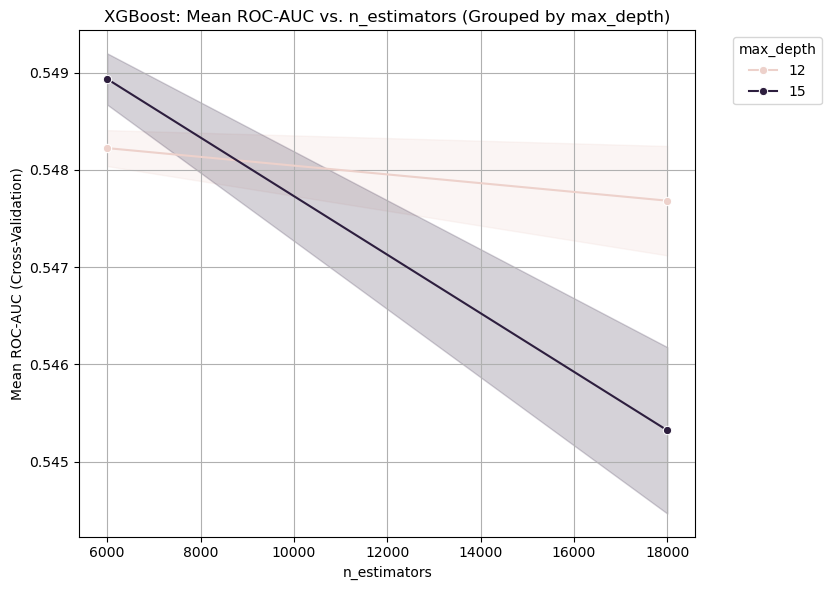

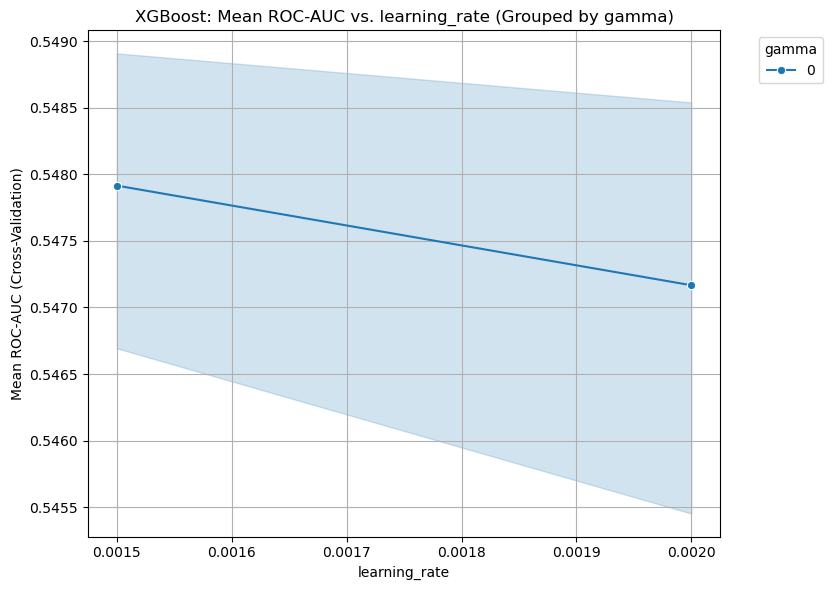

In [ ]:
# --- Plot for XGBoost ---
if 'search_xgb' in locals() and hasattr(search_xgb, 'best_estimator_'):
    print("\n--- Visualizing XGBoost Tuning Results ---")
    # Example: Plot ROC-AUC vs. n_estimators, grouped by max_depth
    plot_cv_results(search_xgb, param_x='n_estimators', param_hue='max_depth', model_name='XGBoost')
    # Example: Plot ROC-AUC vs. learning_rate, grouped by gamma
    plot_cv_results(search_xgb, param_x='learning_rate', param_hue='gamma', model_name='XGBoost')
else:
    print("Cannot plot XGBoost results: 'search_xgb' not found or not fitted.")


In [ ]:
# Make sure the GridSearchCV objects 'search_rf' and 'search_xgb' exist and have been fitted.

print("\n--- Analyzing Feature Importances ---")

# --- Function to Get and Plot Importances ---
def plot_feature_importances(search_cv_object, X_train_cols, model_name, top_n=20):
    """
    Extracts, processes, and plots feature importances from a fitted
    GridSearchCV object containing a Pipeline(preprocessor, classifier).
    """
    print(f"\n--- {model_name} Feature Importances ---")
    try:
        # 1. Access the best pipeline found by GridSearchCV
        best_pipeline = search_cv_object.best_estimator_

        # 2. Access the fitted classifier step
        classifier = best_pipeline.named_steps['classifier']

        # 3. Access the fitted preprocessor step
        preprocessor_fitted = best_pipeline.named_steps['preprocessor']
        print("The preprocessor fitted is: ", preprocessor_fitted)

        # 4. Get feature importances from the classifier
        importances = classifier.feature_importances_

        # 5. Get feature names AFTER preprocessing (including OHE columns)
        # Use the get_feature_names_out method of the fitted ColumnTransformer
        try:
            feature_names = preprocessor_fitted.get_feature_names_out(input_features=X_train_cols)
        except TypeError:
             print("Warning: Using get_feature_names_out without input_features, names might be generic.")
             feature_names = preprocessor_fitted.get_feature_names_out()


        if len(importances) != len(feature_names):
            print(f"Error: Mismatch between number of importances ({len(importances)}) and feature names ({len(feature_names)}). Cannot plot.")
            return None

        # 6. Create a DataFrame for easier handling
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

        # 7. Sort by importance and select top N
        importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

        # 8. Print Top N Importances
        print(f"\nTop {top_n} Features:")
        print(importance_df)

        # 9. Plot Top N Importances
        plt.figure(figsize=(10, top_n / 2.5)) # Adjust figure size based on N
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title(f'Top {top_n} Feature Importances ({model_name})')
        plt.xlabel('Importance Score')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()

        return importance_df # Return the dataframe for potential further use

    except AttributeError as e:
        print(f"Error accessing attributes, likely model or preprocessor steps incorrect: {e}")
        print("Make sure GridSearchCV has run and 'best_estimator_' contains a Pipeline named 'preprocessor' and 'classifier'.")
        return None
    except Exception as e:
        print(f"An error occurred during importance calculation/plotting: {e}")
        return None

# --- Generate Importances for Random Forest ---
# Ensure X_train still holds the original columns before preprocessing within the pipeline
if 'search_rf' in locals() and hasattr(search_rf, 'best_estimator_'):
    plot_feature_importances(search_rf, X_train.columns, "Random Forest")
else:
    print("GridSearchCV object 'search_rf' not found or not fitted. Skipping RF importance plot.")


# --- Generate Importances for XGBoost ---
if 'search_xgb' in locals() and hasattr(search_xgb, 'best_estimator_'):
    plot_feature_importances(search_xgb, X_train.columns, "XGBoost")
else:
     print("GridSearchCV object 'search_xgb' not found or not fitted. Skipping XGBoost importance plot.")

In [ ]:
# 'best_xgb_model' is the fitted Pipeline object from GridSearchCV
# 'X_train' is the training feature DataFrame (before preprocessing in pipeline)
# 'interaction_df_final' or similar holds the original data used for X/y split

print("\n--- Defining Recommendation Function using XGBoost Model ---")

def recommend_universities_xgb(student_profile_dict, model_pipeline, candidate_universities, original_feature_columns, top_n=10):
    """
    Generates university recommendations for a student using a trained XGBoost pipeline.

    Args:
        student_profile_dict (dict): Dictionary containing the new student's features.
                                     Keys must match original feature columns before preprocessing.
        model_pipeline (Pipeline): The fitted Scikit-learn pipeline (preprocessor + XGBoost).
        candidate_universities (list): A list of university names to score.
        original_feature_columns (list): The list of feature column names expected by the
                                         pipeline's preprocessor (e.g., X_train.columns).
        top_n (int): The number of top recommendations to return.

    Returns:
        pandas.DataFrame: DataFrame with 'UniversityName' and 'AdmissionProbability',
                          sorted by probability, limited to top_n.
                          Returns empty DataFrame on error or no candidates.
    """
    if not candidate_universities:
        print("Warning: No candidate universities provided.")
        return pd.DataFrame({'UniversityName': [], 'AdmissionProbability': []})

    print(f"Generating predictions for {len(candidate_universities)} candidate universities...")

    # 1. Create input DataFrame for prediction
    # Repeat student profile for each candidate university
    student_df_list = []
    for university in candidate_universities:
        profile = student_profile_dict.copy()
        profile['UniversityName'] = university # Add the specific university name
        student_df_list.append(profile)

    input_df = pd.DataFrame(student_df_list)

    # Ensure columns match the order expected by the fitted preprocessor
    try:
        input_df = input_df[original_feature_columns]
    except KeyError as e:
         print(f"Error: Input student profile is missing expected columns: {e}. Cannot predict.")
         print(f"Expected columns: {original_feature_columns}")
         print(f"Provided keys: {student_profile_dict.keys()}")
         return pd.DataFrame({'UniversityName': [], 'AdmissionProbability': []})


    # 2. Predict Probabilities using the full pipeline
    # The pipeline handles preprocessing internally before prediction
    try:
        print("Predicting probabilities...")
        probabilities = model_pipeline.predict_proba(input_df)
        # Probabilities array has shape (n_samples, n_classes), we want class 1 (Admitted)
        admission_probabilities = probabilities[:, 1]
        print("Prediction complete.")
    except Exception as e:
        print(f"Error during prediction: {e}")
        # Potentially print input_df.info() here for debugging
        return pd.DataFrame({'UniversityName': [], 'AdmissionProbability': []})


    # 3. Rank Universities
    results_df = pd.DataFrame({
        'UniversityName': candidate_universities,
        'AdmissionProbability': admission_probabilities
    })

    results_df = results_df.sort_values(by='AdmissionProbability', ascending=False)

    # 4. Return Top N
    return results_df.head(top_n)


# --- Example Usage ---

# ** PRE-REQUISITES **
# Ensure these exist from previous steps:
# - best_xgb_model: The fitted pipeline from GridSearchCV (search_xgb.best_estimator_)
# - X_train: The DataFrame used to train the model (needed for column names/order and candidate unis)

if 'best_xgb_model' in locals() and 'X_train' in locals():
    print("\n--- Generating Example Recommendations ---")

    # 1. Define a New Student Profile (Use exact column names from X_train)
    new_student = {
        'Overall_GPA_4_Scale': 3.7, # Example GPA
        'Total_Score_Language_Exam': 105.0, # Example TOEFL score
        'Language_Exam': 'TOEFL',
        'Total_Score_Competitive_Exam': 325.0, # Example GRE score
        'Competitive_Exam': 'GRE',
        'Years_Since_Grad': 0,
        'Future_Desired_Degree': 'Masters',
        'Desired_Field_of_Study': 'Computer Science', # Match categories used in training
        'Desired_Specialization': 'Software Engineering' # Match categories used in training
    }
    print(f"New student profile: {new_student}")


    # 2. Get Candidate Universities (e.g., all unique universities seen in training)
    #    Using X_train['UniversityName'] avoids data leakage from test set
    try:
        candidate_universities = X_train['UniversityName'].unique().tolist()
        print(f"Number of candidate universities from training data: {len(candidate_universities)}")
    except KeyError:
         print("Error: 'UniversityName' column not found in X_train. Cannot get candidates.")
         candidate_universities = []


    # 3. Get Original Feature Columns Order (from X_train used to fit preprocessor)
    original_feature_columns = X_train.columns.tolist()


    # 4. Call the Recommendation Function
    if candidate_universities:
        recommendations_df = recommend_universities_xgb(
            student_profile_dict=new_student,
            model_pipeline=best_xgb_model,
            candidate_universities=candidate_universities,
            original_feature_columns=original_feature_columns,
            top_n=10 # Request top 10 recommendations
        )

        print("\n--- Top Recommended Universities ---")
        print(recommendations_df)
    else:
        print("\nCannot generate recommendations as no candidate universities were found.")

else:
    print("\nCould not run example: 'best_xgb_model' or 'X_train' not found in environment.")

In [ ]:
X_train.columns.tolist()

In [ ]:
import random

def generate_sample_student_profiles(num_profiles=10, seed=42):
    """
    Generates sample student profiles for testing university recommendation system.

    Args:
        num_profiles (int): Number of student profiles to generate
        seed (int): Random seed for reproducibility

    Returns:
        list: List of dictionaries containing student profile data
    """

    random.seed(seed)
    np.random.seed(seed)


    language_exams = ['TOEFL', 'IELTS', 'PTE']


    competitive_exams_by_degree = {
        'Bachelors': ['SAT', 'None'],
        'Masters': ['GRE', 'None'],
        'PhD': ['GRE', 'None'],
        'MBA': ['GMAT', 'None']
    }

    desired_degrees = ['Masters', 'PhD', 'Bachelors']
    fields_of_study = [
        'Computer Science', 'Electrical Engineering', 'Mechanical Engineering',
        'Civil Engineering', 'Business Administration', 'Data Science',
        'Physics', 'Mathematics', 'Biology', 'Chemistry', 'MBA'
    ]

    specializations = {
        'Computer Science': ['Software Engineering', 'Machine Learning', 'AI', 'Cybersecurity', 'Computer Vision'],
        'Electrical Engineering': ['Power Systems', 'Electronics', 'Signal Processing', 'Robotics'],
        'Mechanical Engineering': ['Thermodynamics', 'Manufacturing', 'Fluid Mechanics', 'Robotics'],
        'Civil Engineering': ['Structural', 'Transportation', 'Environmental', 'Geotechnical'],
        'Business Administration': ['Finance', 'Marketing', 'Management', 'Supply Chain'],
        'Data Science': ['Machine Learning', 'Big Data', 'Statistical Analysis', 'NLP'],
        'Physics': ['Quantum Mechanics', 'Astrophysics', 'Condensed Matter', 'Optics'],
        'Mathematics': ['Pure Mathematics', 'Applied Mathematics', 'Statistics', 'Operations Research'],
        'Biology': ['Molecular Biology', 'Genetics', 'Ecology', 'Microbiology'],
        'Chemistry': ['Organic Chemistry', 'Inorganic Chemistry', 'Physical Chemistry', 'Biochemistry'],
        'MBA': ['Finance', 'Marketing', 'Management', 'Supply Chain', 'Operations']
    }

    profiles = []

    for _ in range(num_profiles):
        gpa = round(random.uniform(2.5, 4.0), 2)

        language_exam = random.choice(language_exams)
        if language_exam == 'TOEFL':
            language_score = random.randint(80, 120)
        elif language_exam == 'IELTS':
            language_score = round(random.uniform(4.0, 9.0), 1)
        else:  # PTE
            language_score = random.randint(50, 90)

        # Select degree & field first to determine appropriate competitive exams
        degree = random.choice(desired_degrees)
        field = random.choice(fields_of_study)

        specialization = random.choice(specializations[field])

        if(degree == 'PhD' and field == 'MBA'):
            competitive_exam = 'GMAT'
        else:
            competitive_exam = random.choice(competitive_exams_by_degree[degree])

        # Generate score based on exam type
        if competitive_exam == 'GRE':
            competitive_score = random.randint(280, 340)
        elif competitive_exam == 'GMAT':
            competitive_score = random.randint(500, 780)
        elif competitive_exam == 'SAT':
            competitive_score = random.randint(1000, 1600)
        else:  # None
            competitive_score = np.nan


        profile = {
            'Overall_GPA_4_Scale': gpa,
            'Language_Exam': language_exam,
            'Total_Score_Language_Exam': language_score,
            'Competitive_Exam': competitive_exam,
            'Total_Score_Competitive_Exam': competitive_score,
            'Future_Desired_Degree': degree,
            'Desired_Field_of_Study': field,
            'Desired_Specialization': specialization,
            'Years_Since_Grad': random.randint(0, 3)
        }

        profiles.append(profile)

    return profiles

def print_student_profile(profile, index=None):
    """
    Formats and prints a student profile in a readable way.

    Args:
        profile (dict): Student profile dictionary
        index (int, optional): Profile index number
    """
    index_str = f"Profile #{index}: " if index is not None else ""
    print(f"\n{index_str}Student Profile")
    print("=" * 40)
    print(f"GPA: {profile['Overall_GPA_4_Scale']}")
    print(f"Language Exam: {profile['Language_Exam']} - Score: {profile['Total_Score_Language_Exam']}")

    if pd.notna(profile['Total_Score_Competitive_Exam']):
        print(f"Competitive Exam: {profile['Competitive_Exam']} - Score: {profile['Total_Score_Competitive_Exam']}")
    else:
        print(f"Competitive Exam: None")

    print(f"Desired Degree: {profile['Future_Desired_Degree']}")
    print(f"Field of Study: {profile['Desired_Field_of_Study']}")
    print(f"Specialization: {profile['Desired_Specialization']}")
    print(f"Years Since Graduation: {profile['Years_Since_Grad']}")
    print("=" * 40)

def batch_recommend_universities(profiles, model_pipeline, candidate_universities, original_feature_columns,
                               recommend_func, top_n=10, verbose=True):
    """
    Runs the university recommender on multiple student profiles and returns the results.

    Args:
        profiles (list): List of student profile dictionaries
        model_pipeline: The fitted model pipeline
        candidate_universities (list): List of candidate universities
        original_feature_columns (list): List of original feature column names
        recommend_func (function): The recommendation function
        top_n (int): Number of recommendations to return per profile
        verbose (bool): Whether to print detailed output

    Returns:
        list: List of recommendation DataFrames, one per profile
    """
    results = []

    for i, profile in enumerate(profiles):
        if verbose:
            print_student_profile(profile, i+1)
            print(f"Generating recommendations for Profile #{i+1}...")

        # Get recommendations
        recommendations = recommend_universities_xgb(
            student_profile_dict=profile,
            model_pipeline=model_pipeline,
            candidate_universities=candidate_universities,
            original_feature_columns=original_feature_columns,
            top_n=top_n
        )

        if verbose:
            print("\nTop Recommended Universities:")
            if not recommendations.empty:
                # Format probability as percentage
                display_recs = recommendations.copy()
                display_recs['Admission Probability'] = (display_recs['AdmissionProbability'] * 100).round(2).astype(str) + '%'
                print(display_recs[['UniversityName', 'Admission Probability']].to_string(index=False))
            else:
                print("No recommendations generated.")
            print("\n" + "-" * 60 + "\n")

        results.append(recommendations)

    return results

In [ ]:
if 'best_xgb_model' in locals() and 'X_train' in locals():
    # Generate sample profiles
    sample_profiles = generate_sample_student_profiles(num_profiles=10)

    # Get candidate universities and feature columns from training data
    candidate_universities = X_train['UniversityName'].unique().tolist()
    original_feature_columns = X_train.columns.tolist()

    # Run batch recommendations
    results = batch_recommend_universities(
        profiles=sample_profiles,
        model_pipeline=best_xgb_model,
        candidate_universities=candidate_universities,
        original_feature_columns=original_feature_columns,
        recommend_func=recommend_universities_xgb,
        top_n=10,
        verbose=True
    )

###Multi-Class Classification

In [ ]:
 --- 1. Filter for Admitted Cases Only ---
print(f"\nFiltering for records where '{TARGET_COLUMN}' == 1...")
admitted_df = combined_df[combined_df[TARGET_COLUMN] == 1].copy()
print(f"Shape after filtering for admitted cases: {admitted_df.shape}")

if admitted_df.empty:
    raise ValueError("No admitted cases found in combined_df. Cannot proceed with multi-class model.")


In [ ]:
# --- 2. Create the New Concatenated Multi-Class Target Variable ---
# Define the columns that will form the new target
uni_col = 'UniversityName'
course_col = 'Desired_Field_of_Study'
degree_col = 'Future_Desired_Degree'
new_target_col_multiclass = 'Uni_Course_Degree_Target'

print(f"\nCreating concatenated target variable '{new_target_col_multiclass}'...")
# Ensure categorical columns used for target are string type and handle potential NaNs in them
# (although after imputation, they should ideally be filled, e.g., with 'Missing')
admitted_df[uni_col] = admitted_df[uni_col].astype(str).fillna('UnknownUniversity')
admitted_df[course_col] = admitted_df[course_col].astype(str).fillna('UnknownCourse')
admitted_df[degree_col] = admitted_df[degree_col].astype(str).fillna('UnknownDegree')

admitted_df[new_target_col_multiclass] = (
    admitted_df[uni_col] + "_" +
    admitted_df[course_col] + "_" +
    admitted_df[degree_col]
)
print(f"  Number of unique classes in '{new_target_col_multiclass}': {admitted_df[new_target_col_multiclass].nunique()}")
print(f"  Example target values:\n{admitted_df[new_target_col_multiclass].head()}")


In [ ]:
# --- 3. Define Input Features (Student-Specific Academic Profile) ---
# These are the features the model will use to predict the multi-class target.
# Ensure these columns exist in 'admitted_df' and have been imputed if necessary.
student_academic_features = [
    'Overall_GPA_4_Scale',
    'Total_Score_(Competitive_Exam)',
    'Total_Score_(Language_Exam)',
    'Years_Since_Grad'
]
# Filter based on actual columns present (should all be there if core_features included them)
X_multiclass_features = [col for col in student_academic_features if col in admitted_df.columns]

if len(X_multiclass_features) != len(student_academic_features):
    print(f"Warning: Not all expected student academic features found. Using: {X_multiclass_features}")
    if not X_multiclass_features:
        raise ValueError("No student academic features selected. Cannot proceed.")

print(f"\nInput features for multi-class model: {X_multiclass_features}")
X_multiclass = admitted_df[X_multiclass_features]


In [ ]:
# --- 4. Define and Encode the Multi-Class Target Variable ---
# Machine learning models need numerical targets. We'll use LabelEncoder.
y_multiclass_str = admitted_df[new_target_col_multiclass]

label_encoder = LabelEncoder()
y_multiclass = label_encoder.fit_transform(y_multiclass_str)

print(f"\nEncoded multi-class target variable 'y_multiclass'.")
print(f"  Shape of X_multiclass: {X_multiclass.shape}")
print(f"  Shape of y_multiclass: {y_multiclass.shape}")
# You can save the label_encoder to decode predictions later:
# joblib.dump(label_encoder, 'multiclass_target_label_encoder.joblib')


In [ ]:
# --- 5. Train-Test Split for Multi-Class Model ---
print("\nSplitting data for multi-class model...")
# Check for NaNs in y_multiclass - should not happen if target creation was robust
if pd.Series(y_multiclass).isnull().any():
    raise ValueError("NaN values found in the encoded target variable y_multiclass. Check target creation.")

# Check if X_multiclass still has NaNs.
# These should have been imputed *before* this script.
# If not, the model training will fail or SimpleImputer is needed in the new pipeline.
print(f"NaN counts in X_multiclass before split:\n{X_multiclass.isnull().sum()}")
if X_multiclass.isnull().any().any():
    print("Warning: X_multiclass contains NaN values. Ensure imputation was done or add to pipeline.")


X_train_mc, X_test_mc, y_train_mc, y_test_mc = train_test_split(
    X_multiclass, y_multiclass,
    test_size=0.20,
    random_state=42,
    stratify=y_multiclass # Stratify by the new multi-class target
)

print(f"\nMulti-class data split completed:")
print(f"  Train set shape: X_train_mc={X_train_mc.shape}, y_train_mc={y_train_mc.shape}")
print(f"  Test set shape:  X_test_mc={X_test_mc.shape}, y_test_mc={y_test_mc.shape}")
# print(f"  Target distribution in y_train_mc (top 5 classes):\n{pd.Series(y_train_mc).value_counts(normalize=True).head()}")
# print(f"  Target distribution in y_test_mc (top 5 classes):\n{pd.Series(y_test_mc).value_counts(normalize=True).head()}")

print("\nData preparation for multi-class model complete.")
# Variables X_train_mc, X_test_mc, y_train_mc, y_test_mc are ready for
# defining a new preprocessing pipeline (simpler, for numerical features) and model training.
# The 'label_encoder' object can be used to convert numerical predictions back to string labels.


#ONNX Conversion

In [ ]:
!pip install onnxconverter-common

In [ ]:
!pip install onnxmltools

In [ ]:
!pip install onnxruntime

In [ ]:
!pip install skl2onnx

In [ ]:
import onnx
from skl2onnx import convert_sklearn
from skl2onnx.common.utils import check_input_and_output_numbers
from skl2onnx.algebra.onnx_ops import OnnxSlice, OnnxSub, OnnxDiv, OnnxMul, OnnxCastLike, OnnxClip
from skl2onnx import update_registered_converter, to_onnx, convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, Int64TensorType, StringTensorType,Int32TensorType,DoubleTensorType

In [ ]:
#Improved Convertor
def improved_convert_model_to_onnx(best_xgb_model, X_train, target_opset=15, output_path="university_recommendation_model.onnx"):
    """Convert the XGBoost model to ONNX format with proper categorical feature handling."""
    try:
        from sklearn.pipeline import Pipeline
        from onnxmltools.convert import convert_xgboost
        from skl2onnx import convert_sklearn
        import onnxmltools
        import numpy as np

        print("Starting ONNX conversion...")

        # Check if the model is a pipeline
        if isinstance(best_xgb_model, Pipeline):
            print("Model is a Pipeline. Finding preprocessing steps and XGBoost model...")

            # Find preprocessing steps and XGBoost model
            xgb_step = None
            preprocessor = None

            for step_name, step_estimator in best_xgb_model.named_steps.items():
                if 'XGB' in type(step_estimator).__name__:
                    xgb_step = step_estimator
                    print(f"Found XGBoost step: {step_name}")
                else:
                    # Collect preprocessor steps that happen before XGBoost
                    if preprocessor is None:
                        preprocessor = step_estimator
                        print(f"Found preprocessor step: {step_name}")

            if xgb_step is None:
                print("No XGBoost model found in pipeline.")
                return None

            # First, apply preprocessing to X_train to get the transformed data
            if preprocessor is not None:
                print("Applying preprocessing to get feature names...")
                X_transformed = preprocessor.transform(X_train)

                # Get feature names from preprocessing if possible
                if hasattr(preprocessor, 'get_feature_names_out'):
                    feature_names = preprocessor.get_feature_names_out()
                    print(f"Features after preprocessing: {len(feature_names)}")
                else:
                    # If feature names aren't available, create generic ones
                    feature_names = [f'f{i}' for i in range(X_transformed.shape[1])]
                    print(f"Created generic feature names: {len(feature_names)}")

                # For sparse matrices, convert to dense
                if hasattr(X_transformed, 'toarray'):
                    X_transformed = X_transformed.toarray()

                # Define input type for ONNX conversion based on transformed data
                initial_types = [('input', FloatTensorType([None, X_transformed.shape[1]]))]

                # Convert just the XGBoost model
                print(f"Converting XGBoost model with {len(feature_names)} input features...")
                xgb_onnx = convert_xgboost(xgb_step, initial_types=initial_types, target_opset=target_opset)

                # Save the model
                with open(output_path, "wb") as f:
                    f.write(xgb_onnx.SerializeToString())

                print(f"XGBoost model successfully converted and saved to {output_path}")

                # Return additional info to help with inference
                return {
                    'model': xgb_onnx,
                    'preprocessor': preprocessor,
                    'feature_names': feature_names,
                    'needs_preprocessing': True
                }
            else:
                # If no preprocessor was found, convert the whole pipeline
                print("Converting the entire pipeline...")
                # Define initial types based on the original input data
                initial_types = []
                for col, dtype in zip(X_train.columns, X_train.dtypes):
                    if dtype == 'float64' or dtype == 'float32':
                        initial_types.append((col, FloatTensorType([None, 1])))
                    elif dtype == 'int64' or dtype == 'int32':
                        initial_types.append((col, Int64TensorType([None, 1])))
                    else:  # object/string type
                        initial_types.append((col, StringTensorType([None, 1])))

                model_onnx = convert_sklearn(
                    best_xgb_model,
                    'university_recommendation_xgboost',
                    initial_types,
                    target_opset=target_opset
                )

                # Save the model
                with open(output_path, "wb") as f:
                    f.write(model_onnx.SerializeToString())

                print(f"Pipeline successfully converted and saved to {output_path}")
                return {
                    'model': model_onnx,
                    'preprocessor': None,
                    'feature_names': list(X_train.columns),
                    'needs_preprocessing': False
                }
        else:
            # Direct XGBoost model conversion
            print("Converting standalone XGBoost model...")
            initial_types = [('input', FloatTensorType([None, X_train.shape[1]]))]
            xgb_onnx = convert_xgboost(best_xgb_model, initial_types=initial_types, target_opset=target_opset)

            # Save the model
            with open(output_path, "wb") as f:
                f.write(xgb_onnx.SerializeToString())

            print(f"XGBoost model successfully converted and saved to {output_path}")
            return {
                'model': xgb_onnx,
                'preprocessor': None,
                'feature_names': list(X_train.columns),
                'needs_preprocessing': False
            }

    except Exception as e:
        import traceback
        print(f"Error during ONNX conversion: {type(e).__name__}: {e}")
        print(traceback.format_exc())
        return None

In [ ]:
conversion_result = improved_convert_model_to_onnx(best_xgb_model, X_train)

In [ ]:
def recommend_universities_onnx(student_profile_dict, onnx_model_path, candidate_universities,
                                original_feature_columns, preprocessor=None, top_n=10):
    """
    Generates university recommendations for a student using the ONNX version of the XGBoost model.

    Args:
        student_profile_dict (dict): Dictionary containing student features
        onnx_model_path (str): Path to the ONNX model file
        candidate_universities (list): List of university names to score
        original_feature_columns (list): Feature column names expected by the model
        preprocessor: Optional sklearn preprocessor that was used during training
        top_n (int): Number of top recommendations to return
    """
    try:
        import onnxruntime as rt
        import numpy as np

        if not candidate_universities:
            print("Warning: No candidate universities provided.")
            return pd.DataFrame({'UniversityName': [], 'AdmissionProbability': []})

        print(f"Loading ONNX model from {onnx_model_path}")
        sess = rt.InferenceSession(onnx_model_path)

        # Get input and output names
        input_names = [input.name for input in sess.get_inputs()]
        output_names = [output.name for output in sess.get_outputs()]

        print(f"Model input names: {input_names}")
        print(f"Model output names: {output_names}")

        # Use the first input and output name
        input_name = input_names[0]

        print(f"Generating predictions for {len(candidate_universities)} candidate universities...")

        # Create input DataFrame for prediction
        student_df_list = []
        for university in candidate_universities:
            profile = student_profile_dict.copy()
            profile['UniversityName'] = university
            student_df_list.append(profile)

        input_df = pd.DataFrame(student_df_list)

        # Ensure columns match the order expected by the model
        try:
            input_df = input_df[original_feature_columns]
        except KeyError as e:
            print(f"Error: Input student profile is missing expected columns: {e}. Cannot predict.")
            print(f"Expected columns: {original_feature_columns}")
            print(f"Provided keys: {student_profile_dict.keys()}")
            return pd.DataFrame({'UniversityName': [], 'AdmissionProbability': []})

        # Apply preprocessor if available
        if preprocessor is not None:
            print("Applying preprocessing to input data...")
            X_transformed = preprocessor.transform(input_df)

            # Convert sparse matrix to dense array if needed
            if hasattr(X_transformed, 'toarray'):
                X = X_transformed.toarray().astype(np.float32)
            else:
                X = X_transformed.astype(np.float32)

            print(f"Preprocessed input shape: {X.shape}")
        else:
            # Handle categorical features manually
            print("No preprocessor available. Performing basic encoding...")
            processed_df = input_df.copy()

            # Handle categorical features by one-hot encoding
            categorical_cols = processed_df.select_dtypes(include=['object']).columns

            # Simple one-hot encoding implementation
            if len(categorical_cols) > 0:
                for col in categorical_cols:
                    # Get unique values for this column
                    unique_values = processed_df[col].unique()
                    # Create one-hot encoded columns
                    for value in unique_values:
                        col_name = f"{col}_{value}"
                        processed_df[col_name] = (processed_df[col] == value).astype(int)

                # Drop original categorical columns
                processed_df = processed_df.drop(columns=categorical_cols)

            # Convert to numpy array
            X = processed_df.values.astype(np.float32)
            print(f"Manually encoded input shape: {X.shape}")

        # Run inference
        print("Predicting probabilities with ONNX model...")
        try:
            outputs = sess.run(output_names, {input_name: X})

            # Get probabilities (usually the second output for classifiers)
            if len(outputs) >= 2:  # Classifier with label and probability outputs
                probabilities = outputs[1]  # The second output is typically probabilities
                # For binary classification, class 1 (positive class) is usually at index 1
                admission_probabilities = probabilities[:, 1] if probabilities.shape[1] > 1 else probabilities[:, 0]
            else:  # Regressor or single-output classifier
                admission_probabilities = outputs[0].ravel()

            print("Prediction complete.")

            # Create results DataFrame
            results_df = pd.DataFrame({
                'UniversityName': candidate_universities,
                'AdmissionProbability': admission_probabilities
            })
            results_df = results_df.sort_values(by='AdmissionProbability', ascending=False)

            # Return Top N
            return results_df.head(top_n)

        except Exception as e:
            print(f"Error during inference: {type(e).__name__}: {e}")
            print(f"Input shape: {X.shape}, dtype: {X.dtype}")
            print("Try to save preprocessed data to inspect or verify against model requirements")
            # Save a sample for debugging
            np.savetxt("input_sample.csv", X[:5], delimiter=",")
            print("Sample input saved to input_sample.csv")
            raise

    except Exception as e:
        import traceback
        print(f"Error during ONNX prediction: {type(e).__name__}: {e}")
        print(traceback.format_exc())
        return pd.DataFrame({'UniversityName': [], 'AdmissionProbability': []})

In [ ]:
import pickle

In [ ]:
print("\n--- Generating Example Recommendations Using ONNX Model ---")

# Define a new student profile with the exact column names from X_train
new_student = {
        'Overall_GPA_4_Scale': 4.0,
        'Total_Score_Language_Exam': 8,
        'Language_Exam': 'IELTS',
        'Total_Score_Competitive_Exam': 316.0,
        'Competitive_Exam': 'GRE',
        'Future_Desired_Degree': 'Masters',
        'Desired_Field_of_Study': 'Computer Science',
        'Desired_Specialization': 'Software Engineering',
        'Years_Since_Grad': 1
}

print(f"New student profile: {new_student}")

pre_processor = None
if isinstance(best_xgb_model, Pipeline):
    for step_name, step_estimator in best_xgb_model.named_steps.items():
        if not 'XGB' in type(step_estimator).__name__:
            pre_processor = step_estimator
            with open('preprocessor.pkl', 'wb') as f:
                pickle.dump(pre_processor, f)
            break

# Get Candidate Universities
try:
    candidate_universities = X_train['UniversityName'].unique().tolist()
    print(f"Number of candidate universities from training data: {len(candidate_universities)}")
except KeyError:
    print("Error: 'UniversityName' column not found in X_train. Cannot get candidates.")
    candidate_universities = []

# Get Original Feature Columns Order
original_feature_columns = X_train.columns.tolist()

# Call the ONNX Recommendation Function
if candidate_universities:
      recommendations_df = recommend_universities_onnx(
        student_profile_dict=new_student,
        onnx_model_path="/content/university_recommendation_model.onnx",
        candidate_universities=candidate_universities,
        original_feature_columns=original_feature_columns,
        preprocessor=pre_processor,
        top_n=10)

      print("\n--- Top Recommended Universities (ONNX Model) ---")
      print(recommendations_df)
else:
    print("\nCannot generate recommendations as no candidate universities were found.")